In [2]:
import xarray as xr
import glob
import numpy as np

import tensorflow as tf

from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots
import SCA

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [3]:
imp.reload(preprocessing)
imp.reload(experiment_settings)
imp.reload(build_model)
imp.reload(metricplots)
imp.reload(allthelinalg)
imp.reload(analysisplots)

<module 'analysisplots' from '/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/functions/analysisplots.py'>

### Load all the experiment deets

In [4]:
modelpath = "models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
testvariants = experiment_dict["testvariants"]
seedlist = experiment_dict["seeds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+run

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
inres = experiment_dict["inres"]
transform = ccrs.PlateCarree()
obsyearvec_ERSST = np.arange(1854+3*run+leadtime,2024,)
obsyearvec_HadISST = np.arange(1870+3*run+leadtime,2024,)
modelyearvec = np.arange(year1+2*run+leadtime,2015)
latvec = np.arange(-90+inres/2,90+inres/2,inres)
lonvec = np.arange(0+inres/2,360+inres/2,inres)

weights = np.meshgrid(lon,lat)[1]
latweights = np.sqrt(np.cos(np.deg2rad(weights)))

### Also load in the preprocessed data

In [5]:
datafile = "processed_data/" + filefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"]

trainvaltest = [trainvariants,valvariants,testvariants]

inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
    allinputdata,alloutputdata,trainvaltest,experiment_dict["run"])

inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0

outputstd = np.std(outputdata, axis=0, keepdims=True)
outputdata = outputdata/outputstd
outputval = outputval/outputstd
outputtest = outputtest/outputstd

outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0  

nvars = int(len(valvariants)*len(modellist))
nvariant = len(testvariants)
nmodels = len(modellist)
ntimesteps = int(len(outputtest)/(nvariant*nmodels))
n1model = ntimesteps*nvariant

mask = np.copy(outputtest)
mask[mask==0] = np.nan
landmask = ~np.isnan(np.mean(mask,axis=0))
latweights[~landmask] = 0

conversion done


### Also also load in obs

In [6]:
inputobs_ERSST,outputobs_ERSST = preprocessing.make_inputoutput_obs(experiment_dict,"ERSST")
inputobs_ERSST,outputobs_ERSST = preprocessing.concatobs(inputobs_ERSST,outputobs_ERSST,outputstd,run)

inputobs_HadISST,outputobs_HadISST = preprocessing.make_inputoutput_obs(experiment_dict,"HadISST")
inputobs_HadISST,outputobs_HadISST = preprocessing.concatobs(inputobs_HadISST,outputobs_HadISST,outputstd,run)

### Calculate the PDO in each model individually and also across all models
Or just load it in if I've already calculated and saved it

In [7]:
# PDOfile = "processed_data/" + "PDO_" + filefront + ".npz"
# saveflag = False

# if saveflag:
#     PDOpatterns_singlemodel = preprocessing.PDO_pattern_singlemodel(experiment_dict)
#     PDOpattern_allmodel = preprocessing.PDO_pattern_allmodels(experiment_dict)
    
#     np.savez(PDOfile,
#               PDOpatterns_singlemodel=PDOpatterns_singlemodel,
#               PDOpattern_allmodel=PDOpattern_allmodel,
#               )
# else:
    
#     PDOmat = np.load(PDOfile)
#     PDOpatterns_singlemodel = PDOmat["PDOpatterns_singlemodel"]
#     PDOpattern_allmodel = PDOmat["PDOpattern_allmodel"]
    

### Some useful analysis functions to have here and not in an external file whatever

In [8]:
def reshapengrab(inputmatrix,ind,nmodels,nvariants):

    # grabs all variants (nvariant) for a single climate model data (ind of nmodel) 
    inputshape = inputmatrix.shape
    ntimesteps = int(inputshape[0]/(nmodels*nvariants))
    if len(inputshape) == 3:        
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    outputint = intmatrix[ind]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2],inputshape[3])
    outputmatrix = np.reshape(outputint,shapeout)    
    
    return outputmatrix

def model_member_corr(pattern,outputtest,y_pred_test,nmodels,nvariant,landmask):
    
    modelpearsons = np.empty((nmodels,nvariant))
    modelps = np.empty((nmodels,nvariant))
    
    #modelpearsonsall = np.empty((nmodels))

    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,landmask)
    
    return modelpearsons

def weightedMSE(y_pred,y_true,weights):
    err = ((y_pred-y_true)*weights)
    sqerr = err**2
    mse = np.mean(sqerr)
    return mse

### Load in each trained CNN
Load in the CNNs and predict the validation data and then perform SCA on the output timeseries.
Here we calculate the first skill component, **q** from the validation data with **q** defined as

$$ \Sigma_E \mathbf q = \lambda \Sigma_V \mathbf q$$

Where $\Sigma_E$ is the error covariance matrix, and $\Sigma_V$ is the verification covariance (in this case, the covariance of the validation data). Here, we grab the first skill component, i.e., the component that corresponds to the lowest $\lambda$.

In [9]:
domainMSE = []
SCMSE = []

for random_seed in seedlist:

    fileout = filename + "_seed=" + str(random_seed) +".h5"

    tf.random.set_seed(random_seed)
    np.random.seed(random_seed) 
    
    full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                    experiment_dict, random_seed)  
    
    full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                        loss=tf.keras.losses.MeanSquaredError(), 
                      )

    full_model.load_weights(fileout)
    
    full_model.trainable = False # freeze BN

    y_pred_val = full_model.predict(inputval) 
    
    bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   
    SCtimeseries_true = allthelinalg.index_timeseries(outputval,bestpattern,landmask)
    SCtimeseries_pred = allthelinalg.index_timeseries(y_pred_val,bestpattern,landmask)
    SCtimeseries_err = np.mean((SCtimeseries_true-SCtimeseries_pred)**2)
    
    mse = weightedMSE(y_pred_val,outputval,latweights)
    domainMSE.append(mse)
    SCMSE.append(mse)

domainMSE = np.asarray(domainMSE)
bestseed = np.argmin(domainMSE)


336/336 [==============================] - 1s 3ms/step


336/336 [==============================] - 1s 3ms/step


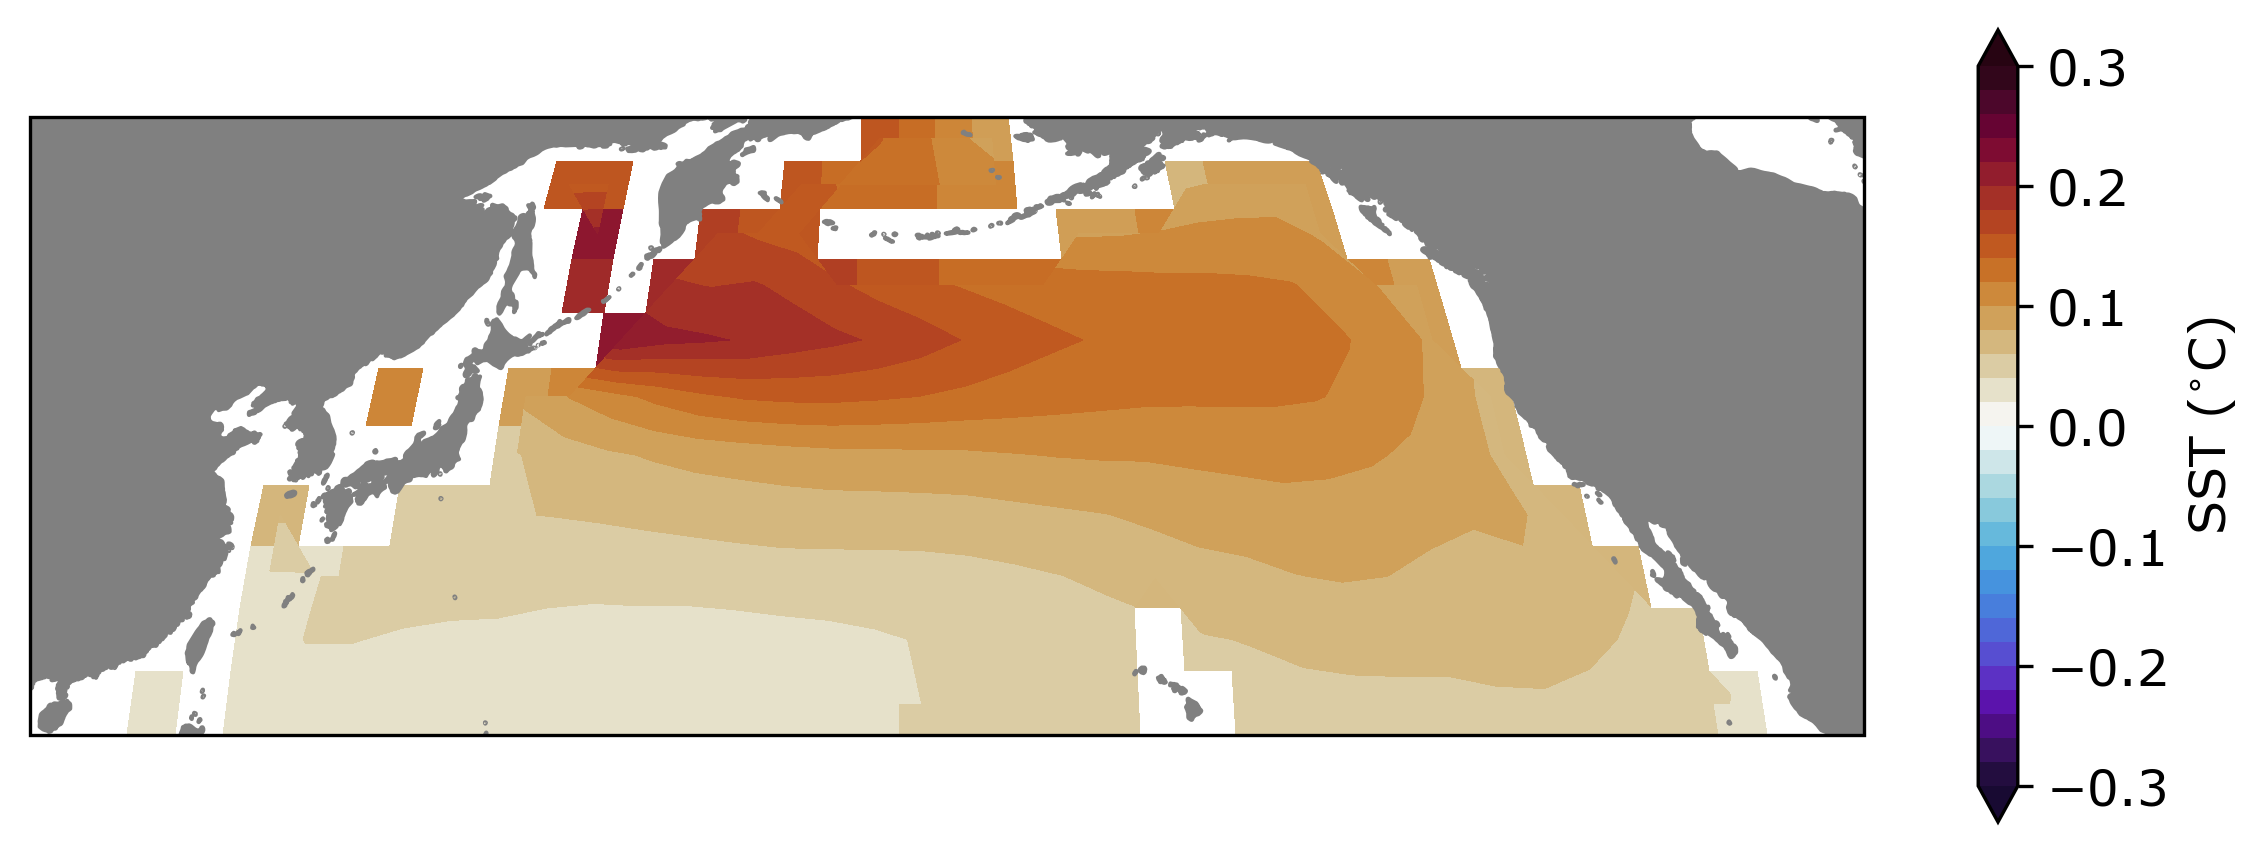

In [10]:
imp.reload(analysisplots)
#for random_seed in seedlist[1:2]:

random_seed = seedlist[bestseed]

fileout = filename + "_seed=" + str(random_seed) +".h5"

tf.random.set_seed(random_seed)
np.random.seed(random_seed) 

full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                experiment_dict, random_seed)  

full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                    loss=tf.keras.losses.MeanSquaredError(), 
                  )

full_model.load_weights(fileout)

full_model.trainable = False # freeze BN

y_pred_test = full_model.predict(inputtest)
y_pred_val = full_model.predict(inputval) 

bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   

patternstr = "figures/CMIP6pattern.png"

analysisplots.plotpattern_SST(bestpattern,lon,lat,outputstd,patternstr)

### Now examine SCA on obs

Take the pattern calculated from the validation data above and project it onto obs, and also the testing members from the GCMs.

5/5 [==============================] - 0s 3ms/step
np conversion done
eof done
np conversion done
eof done


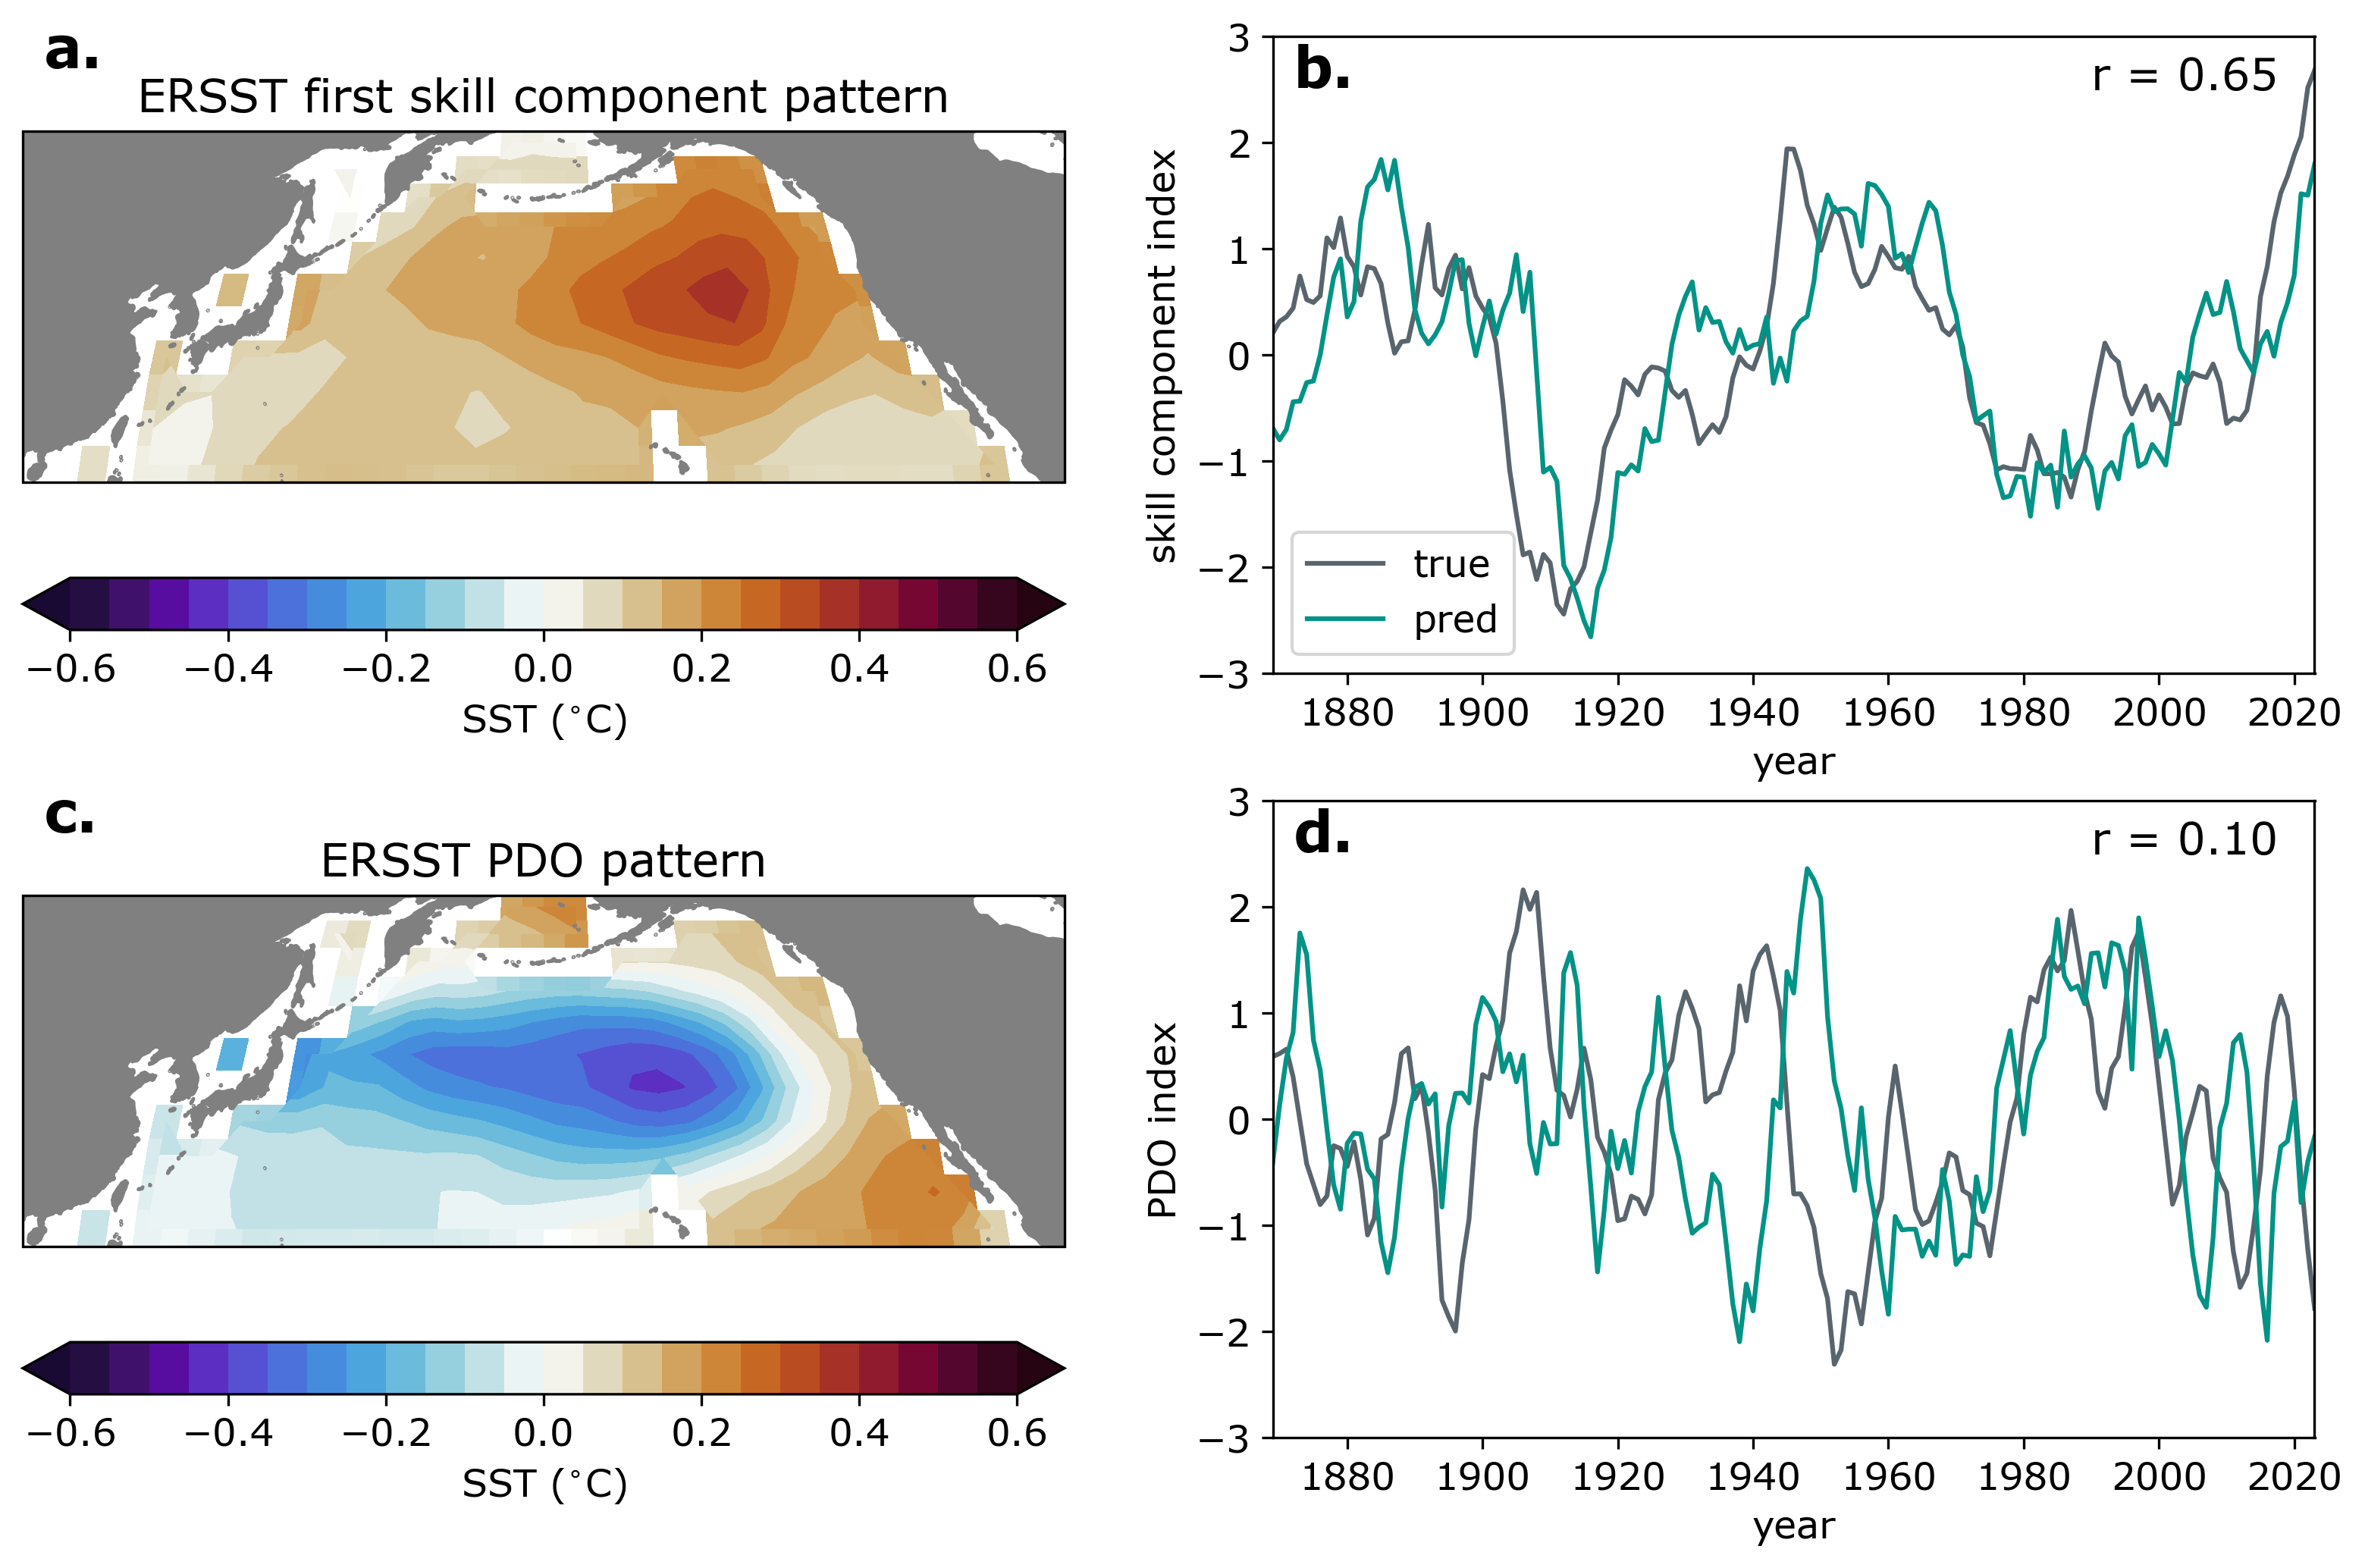

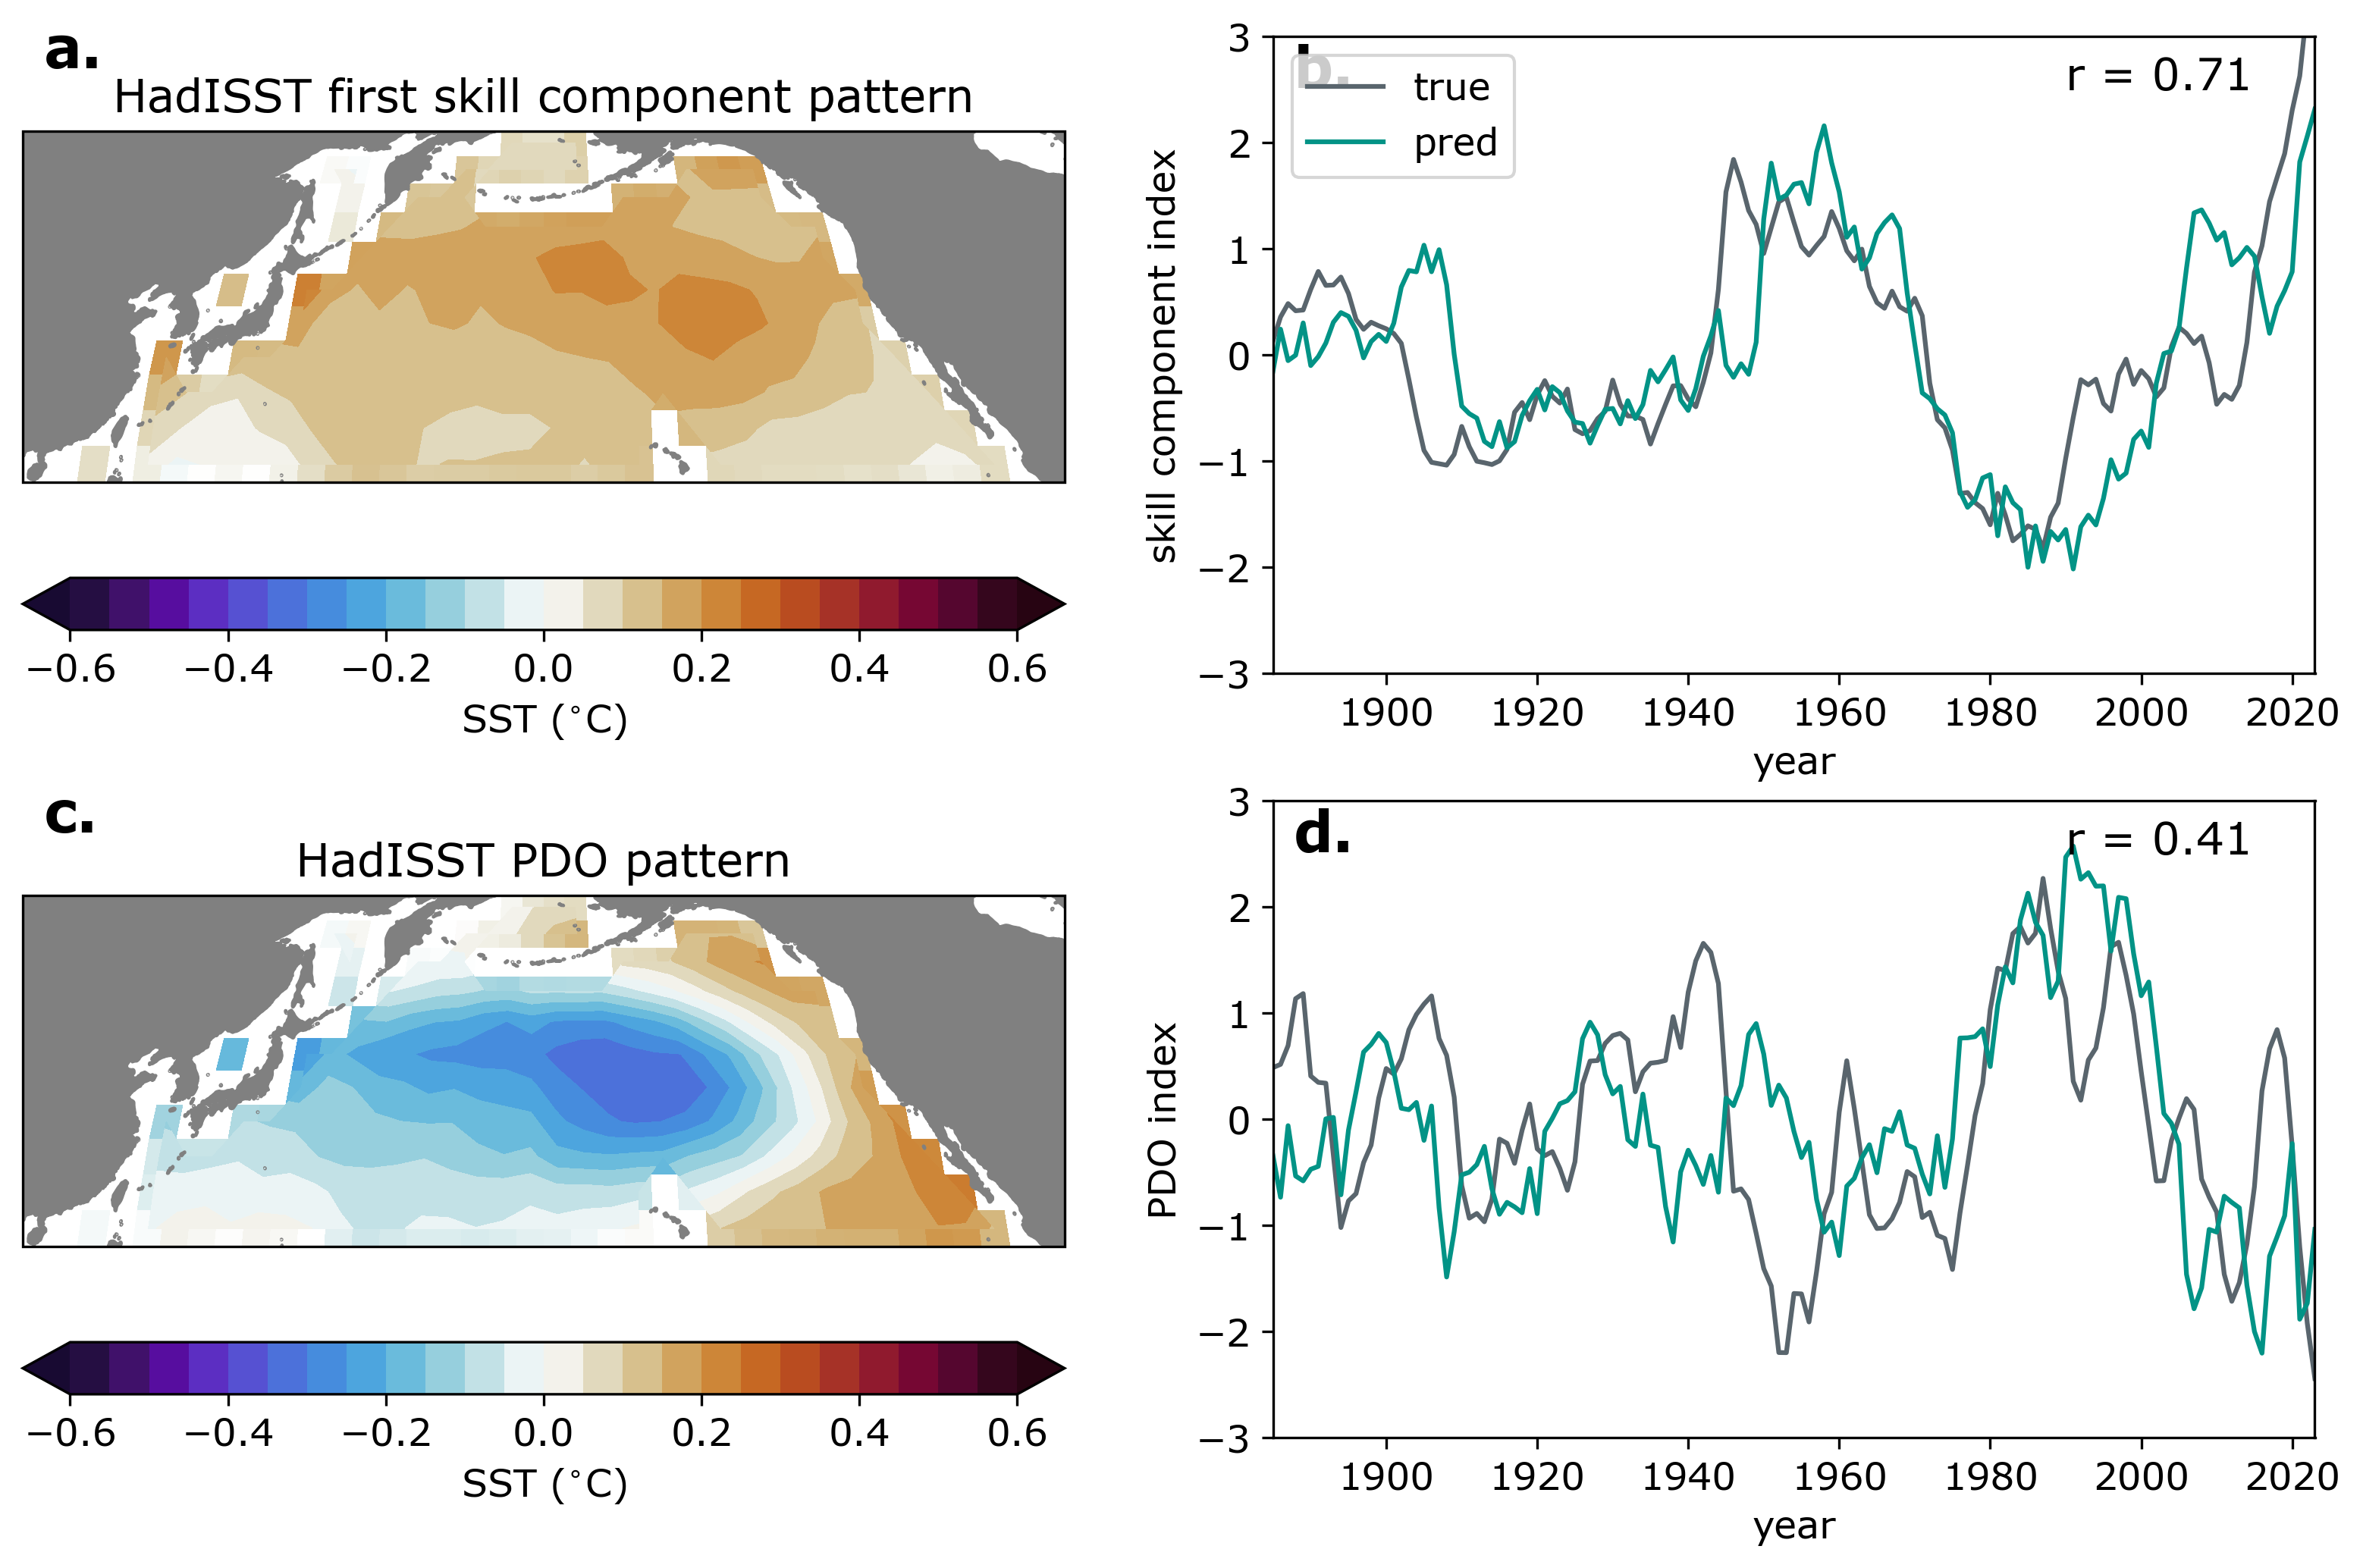

In [39]:
imp.reload(analysisplots)
imp.reload(preprocessing)
y_pred_obs_ERSST = full_model.predict(inputobs_ERSST)
y_pred_obs_ERSST[:,np.sum(outputobs_ERSST,axis=0)==0]=0 # zero out land points

y_pred_obs_HadISST = full_model.predict(inputobs_HadISST)
y_pred_obs_HadISST[:,np.sum(outputobs_HadISST,axis=0)==0]=0 # zero out land points

obsPDO_ERSST = preprocessing.PDOobs(experiment_dict,"ERSST")
obsPDO_ERSST = np.asarray(obsPDO_ERSST)

obsPDO_HadISST = preprocessing.PDOobs(experiment_dict,"HadISST")
obsPDO_HadISST = np.asarray(obsPDO_HadISST)

analysisplots.patternplots_better_SST(bestpattern,obsPDO_ERSST,outputobs_ERSST,y_pred_obs_ERSST,
                             landmask,lon,lat,obsyearvec_ERSST,"ERSST",outputstd)


analysisplots.patternplots_better_SST(bestpattern,obsPDO_HadISST,outputobs_HadISST,y_pred_obs_HadISST,
                             landmask,lon,lat,obsyearvec_HadISST,"HadISST",outputstd)

# for imodel,cmodel in enumerate(modellist):
         
#     outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
#     y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
    
#     outputtest_singlemem = outputtestloop[:ntimesteps]
#     y_pred_test_singlemem = y_pred_testloop[:ntimesteps]

    #analysisplots.patternplots_SST(bestpattern,PDOpatterns_singlemodel[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,
     #                            landmask,lon,lat,modelyearvec,cmodel,outputstd)    

In [12]:
obsyearvec_ERSST.shape
outputobs_ERSST.shape

(155, 11, 38)

### Hmmmm it appears that we are doing well at predicting obs!

Let's find out just how well. Calculate the correlation coefficent between the SC index in truth and predictions for each individual testing ensemble member for each climate model and then also in the observations.

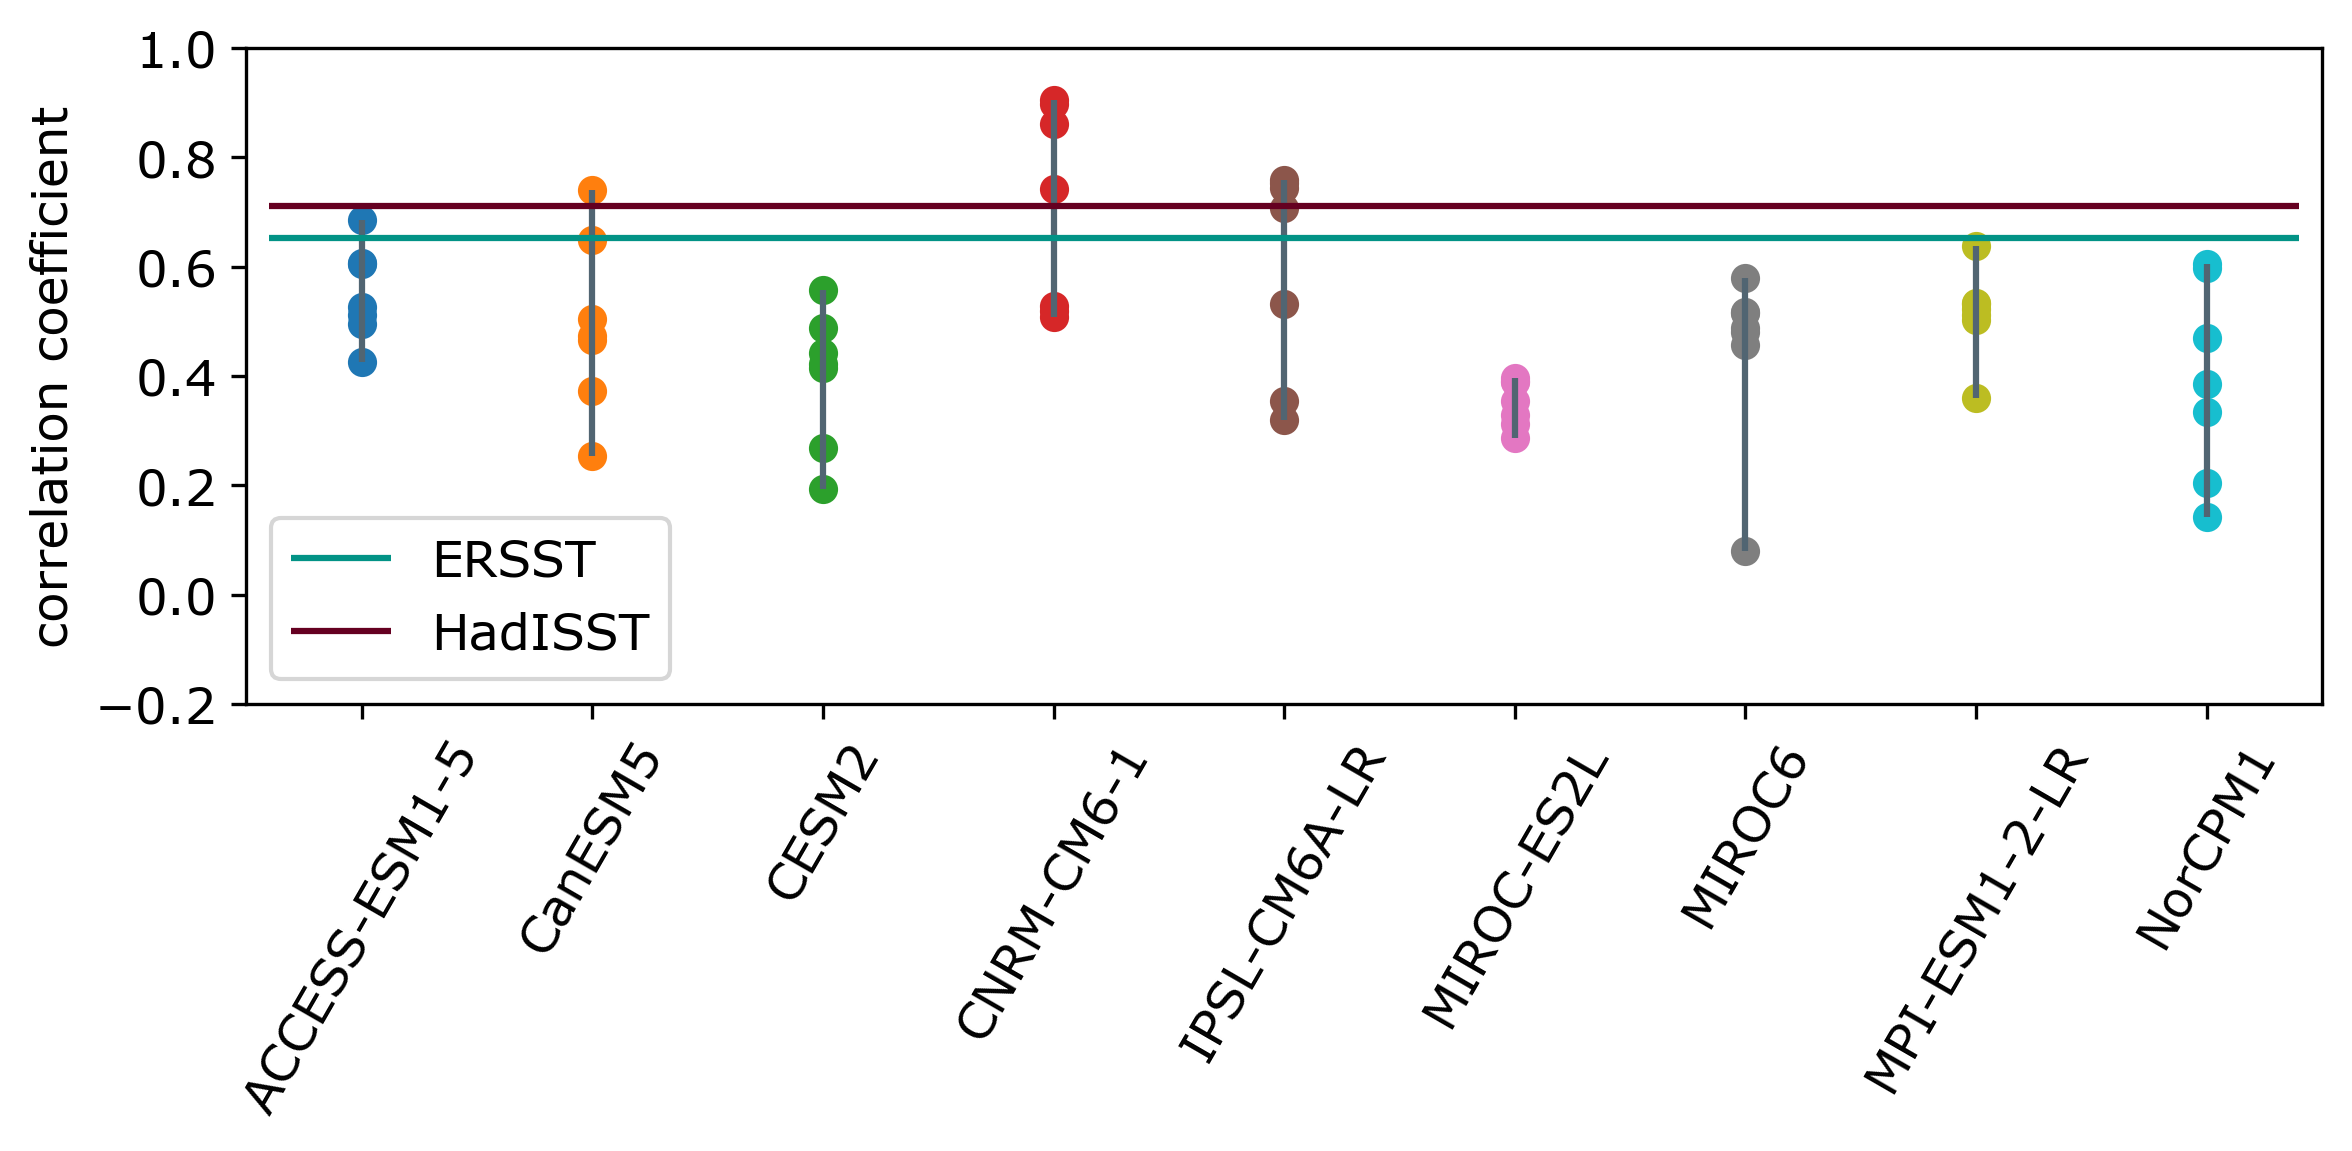

In [13]:
imp.reload(analysisplots)
modelpearsons = model_member_corr(bestpattern,outputtest,y_pred_test,nmodels,nvariant,landmask)
obspearson_ERSST,obsps = allthelinalg.corr_indextimeseries(
    bestpattern,outputobs_ERSST,y_pred_obs_ERSST,landmask)
obspearson_HadISST,obsps = allthelinalg.corr_indextimeseries(
    bestpattern,outputobs_HadISST,y_pred_obs_HadISST,landmask)

obscorrlist = [obspearson_ERSST,
              obspearson_HadISST]

obslabels = ["ERSST","HadISST"]

savestr = "figures/prettyscatterplot_fullmodel.png"
analysisplots.prettyscatterplot(modelpearsons,obscorrlist,modellist,testvariants,"correlation coefficient",obslabels,savestr)


In [14]:
imp.reload(preprocessing)

model_polydetrend_filename = "processed_data/" + filefront + "_imodel_polydetrend.npz"
filecheck = glob.glob(model_polydetrend_filename)

if len(filecheck) == 0:
    inputtest_mat = []
    outputtest_mat = []

    for imodel,cmodel in enumerate(modellist):
        inputtest_leftout,outputtest_leftout = preprocessing.makeinputoutput_imodel_polydetrend(experiment_dict,imodel)

        inputtest_mat.append(inputtest_leftout)
        outputtest_mat.append(outputtest_leftout)

    np.savez(model_polydetrend_filename,
                outputtest_mat = outputtest_mat,
                inputtest_mat = inputtest_mat)
else:
    leftoutdata = np.load(model_polydetrend_filename)
    inputtest_mat = leftoutdata["inputtest_mat"]
    outputtest_mat = leftoutdata["outputtest_mat"]

inputtest_mat = np.asarray(inputtest_mat)
outputtest_mat = np.asarray(outputtest_mat)

In [15]:
inputshape = inputtest_mat.shape
outputshape = outputtest_mat.shape
inputtest_mat = np.reshape(inputtest_mat,(nmodels,30,ntimesteps,inputshape[2],inputshape[3],inputshape[4]))
outputtest_mat = np.reshape(outputtest_mat,(nmodels,30,ntimesteps,outputshape[2],outputshape[3]))

inputtest_polydetrend = np.reshape(inputtest_mat[:,testvariants,:,:,:,:],(nmodels*nvariant*ntimesteps,inputshape[2],inputshape[3],inputshape[4]))
outputtest_polydetrend = np.reshape(outputtest_mat[:,testvariants,:,:,:],(nmodels*nvariant*ntimesteps,outputshape[2],outputshape[3]))

inputtest_polydetrend[:,np.isnan(np.mean(inputtest_polydetrend,axis=0))] = 0
outputtest_polydetrend = outputtest_polydetrend/outputstd
outputtest_polydetrend[:,np.isnan(np.mean(outputtest_polydetrend,axis=0))] = 0

294/294 [==============================] - 1s 3ms/step


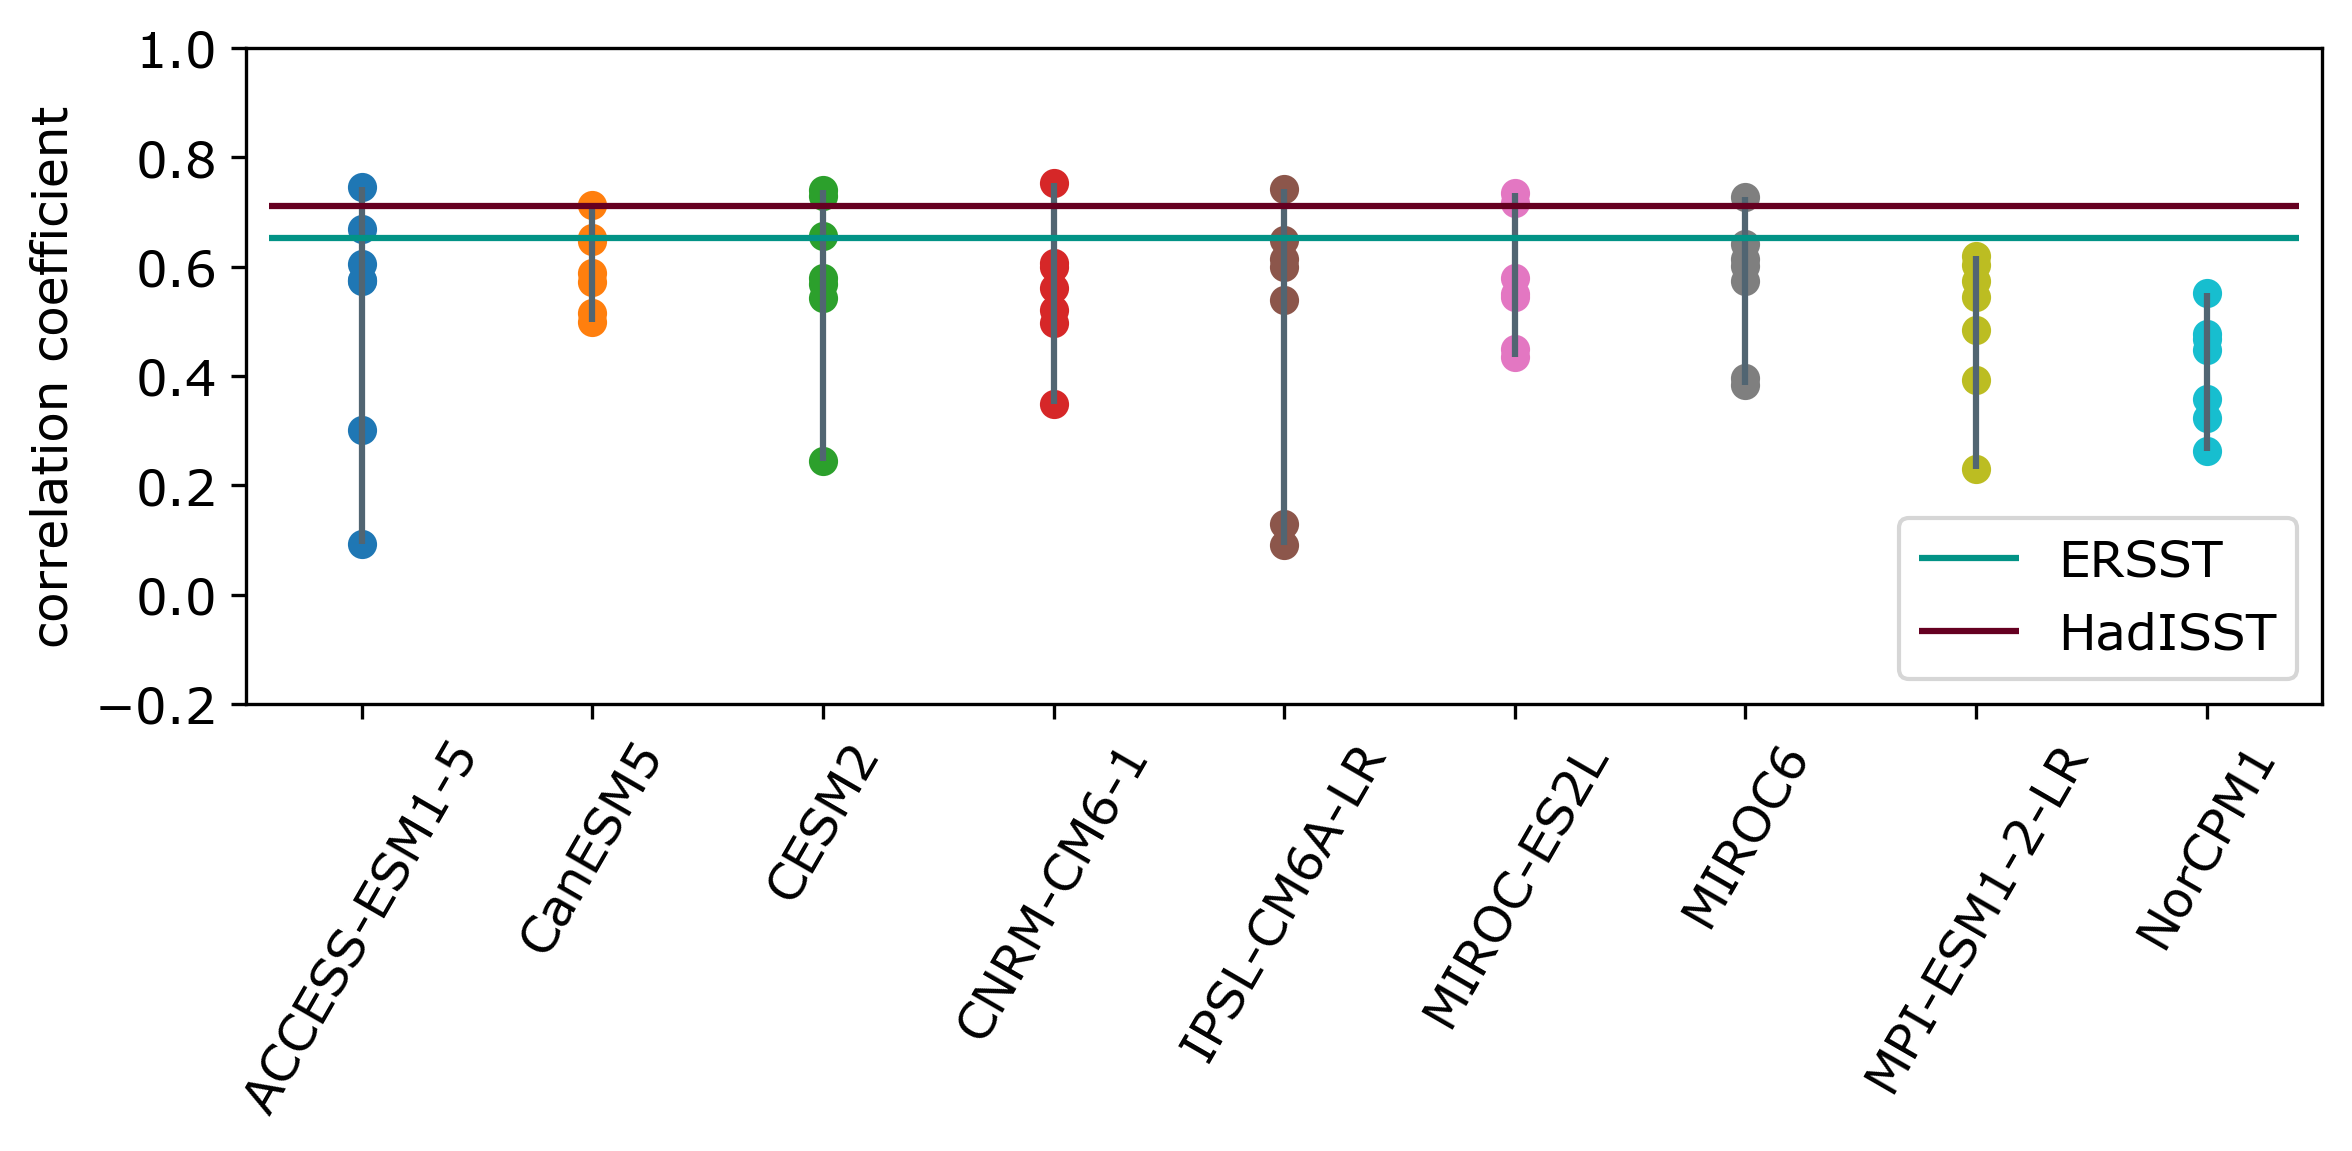

In [33]:
imp.reload(analysisplots)

y_pred_test_polydetrend = full_model.predict(inputtest_polydetrend)

modelpearsons = model_member_corr(bestpattern,outputtest_polydetrend,y_pred_test_polydetrend,nmodels,nvariant,landmask)
obspearson_ERSST,obsps = allthelinalg.corr_indextimeseries(
    bestpattern,outputobs_ERSST,y_pred_obs_ERSST,landmask)
obspearson_HadISST,obsps = allthelinalg.corr_indextimeseries(
    bestpattern,outputobs_HadISST,y_pred_obs_HadISST,landmask)

obscorrlist = [obspearson_ERSST,
              obspearson_HadISST]

obslabels = ["ERSST","HadISST"]

savestr = "figures/prettyscatterplot_fullmodel_polydetrend.png"
analysisplots.prettyscatterplot(modelpearsons,obscorrlist,modellist,testvariants,"correlation coefficient",obslabels,savestr)

### Project the index onto the input data to highlight how the patterns evolve

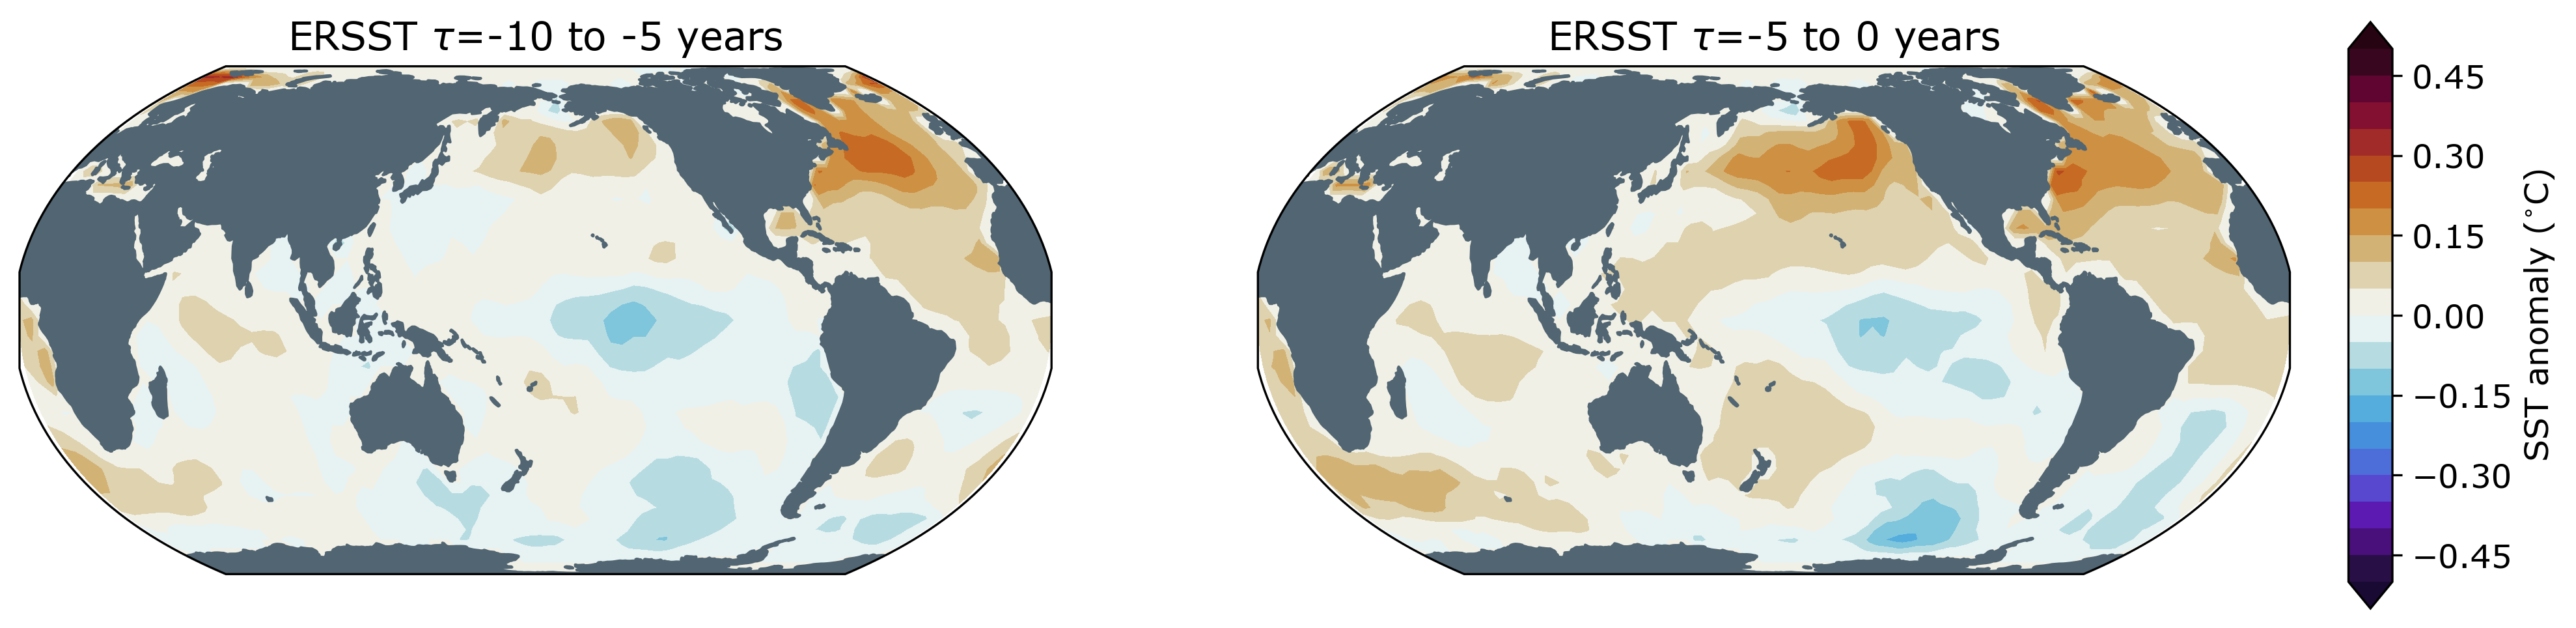

In [17]:
imp.reload(analysisplots)
analysisplots.inputplots(inputobs_ERSST,outputobs_ERSST,bestpattern,landmask,inres,"ERSST")

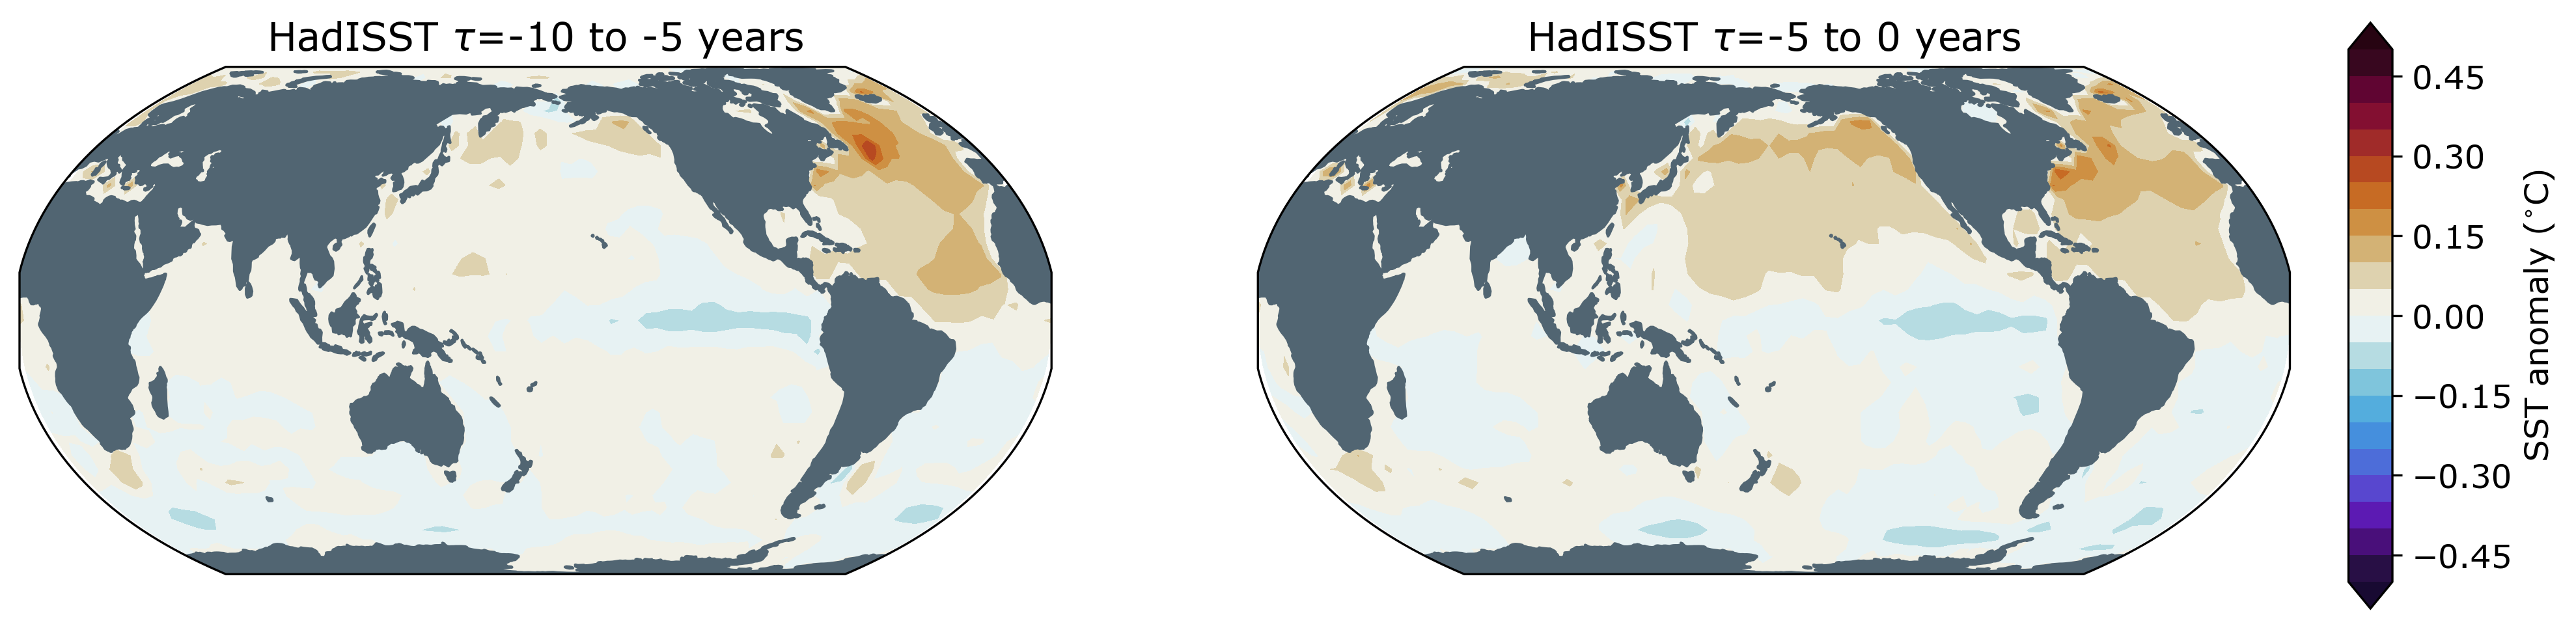

In [18]:
analysisplots.inputplots(inputobs_HadISST,outputobs_HadISST,bestpattern,landmask,inres,"HadISST")

### And each individual model just for fun

In [19]:
# for imodel,cmodel in enumerate(modellist):

#     inputtestloop = reshapengrab(inputtest,imodel,nmodels,nvariant)
#     outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
#     y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
    
#     analysisplots.inputplots(inputtestloop,outputtestloop,bestpattern,landmask,inres,cmodel)

### Variance explained by true pattern at each grid point in obs

/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/functions/analysisplots.py:633: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


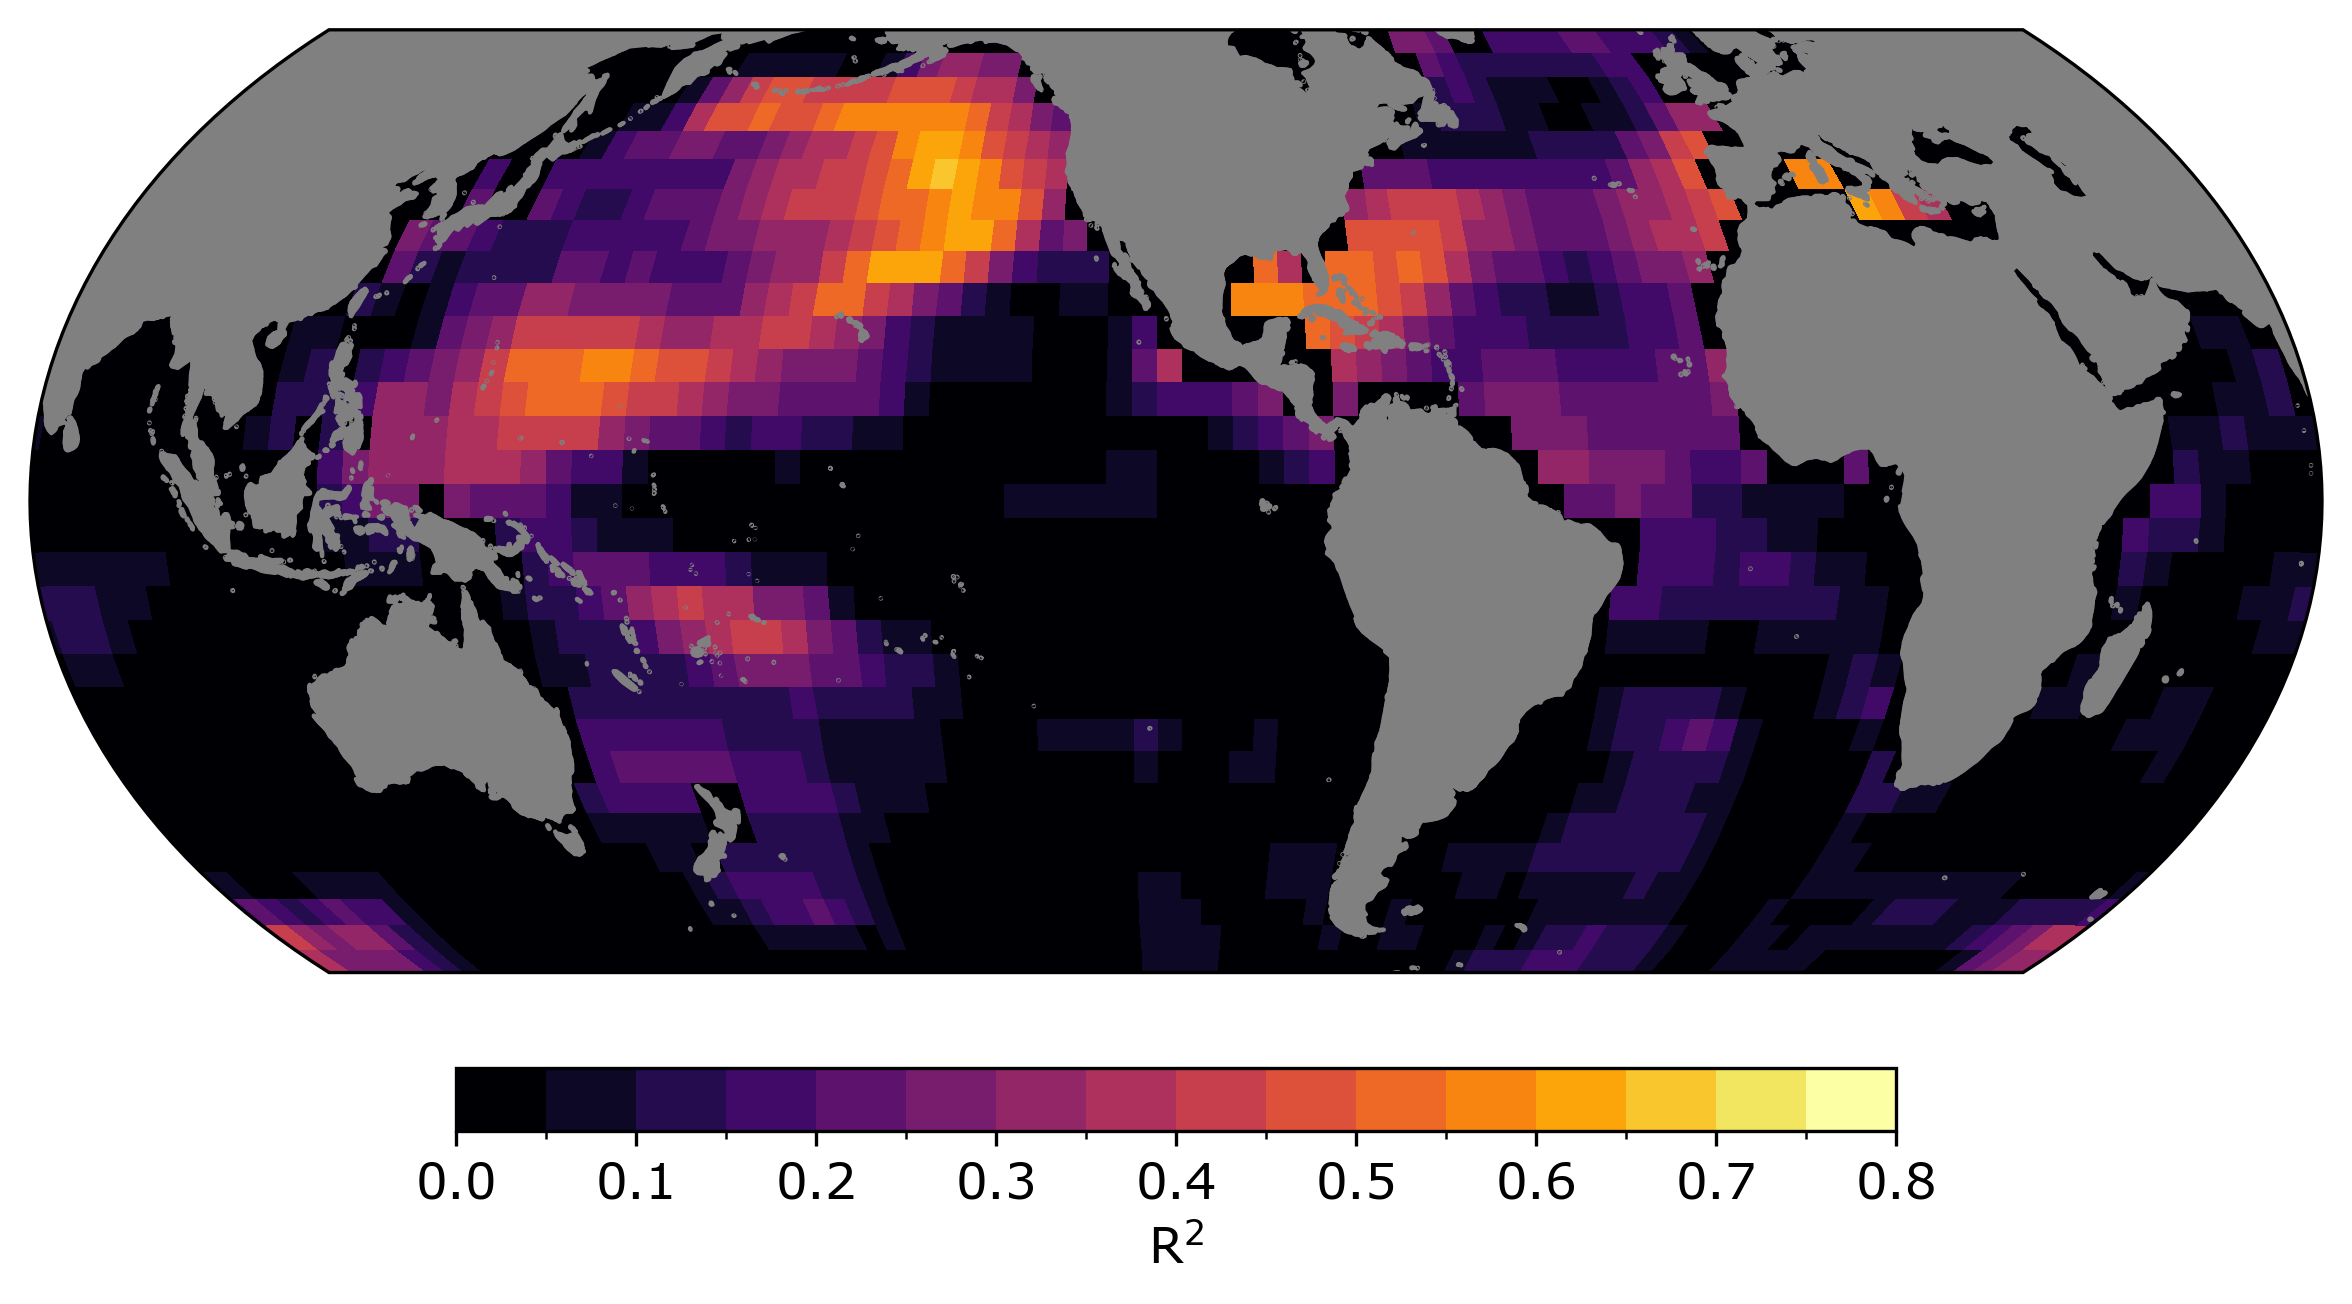

In [20]:
imp.reload(analysisplots)
obs_ersst = preprocessing.makeoutputonly_obs(experiment_dict,"ERSST",[-60,60,0,360])
obs_hadisst = preprocessing.makeoutputonly_obs(experiment_dict,"HadISST",[-60,60,0,360])

biglat = obs_ersst.lat
biglon = obs_ersst.lon

obs_ersst = np.asarray(obs_ersst)
obs_hadisst = np.asarray(obs_hadisst)

obs_ersst[np.isnan(obs_ersst)] = 0
obs_hadisst[np.isnan(obs_hadisst)] = 0

analysisplots.varexplained(y_pred_obs_ERSST,outputobs_ERSST,bestpattern,obs_ersst,landmask,biglat,biglon)

#### A simple linear regression prediction model

We will now use the skill component index to build a SST grid point prediciton model. We estimate the relationship between the ith grid point SST (*SST*$_i$) and the skill component index (*SCI*) using a simple linear regression

$$ SST_i(t) = a_i \times SCI(t) + b_i $$

We estimate the regression parameters using the CMIP6 validation data, and then apply the trained regression at each grid point to the CNN predictions of future SCI index in ERSST ($\widehat{SCI_{CNN}}$), hence

$$ \widehat{SST_i}(t) = a_i \times \widehat{SCI_{CNN}}(t) + b_i $$

On top of this model, we also return the raw CNN skill, and the skill of persistence at each grid point (the next 5 years will look like the last 5 years)

In [21]:
imp.reload(allthelinalg)

outputobs_pred,outputobs_ACC,outputobs_ACC_raw,persistence,MSSS_raw,MSSS_SC = allthelinalg.some_simple_models(
    y_pred_obs_ERSST,outputobs_ERSST,outputval,bestpattern,landmask,lat,lon,run)

/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/functions/allthelinalg.py:95: RuntimeWarning: invalid value encountered in scalar divide
  MSSS_raw[ilat,ilon] = 1-(mse(outputtest[:,ilat,ilon],y_pred_test[:,ilat,ilon])/
/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/functions/allthelinalg.py:97: RuntimeWarning: invalid value encountered in scalar divide
  MSSS_SC[ilat,ilon] = 1-(mse(outputobs_pred[:,ilat,ilon],outputtest[:,ilat,ilon])/


#### Actually, the more difficult part is to estimate the significance of the CNN predictions 
so we use the block bootstrap method outlined by Goddard et. al 2013. We generate a distribution of correlation coefficients by resampling from the prediction/verification data with replacement, then calculating the correlation coefficient. This is repeated nboots times. To account for temporal autocorrelation, our resampling contains 5 year chunks, e.g. if a random time step is selected, then the next 4 years are also selected, then another 5 year chunk is randomly selected, until we have selected the same number of points as in the original forecast timeseries. This forms one iteration of the resampling.

/var/folders/84/qffj5kdx3q15s9xdytp7r01r0000gq/T/ipykernel_15588/3597474699.py:5: RuntimeWarning: invalid value encountered in divide
  obs_auto = np.real(obs_auto[:30]/np.max(obs_auto,axis=0))


Text(0, 0.5, 'decorrelation time')

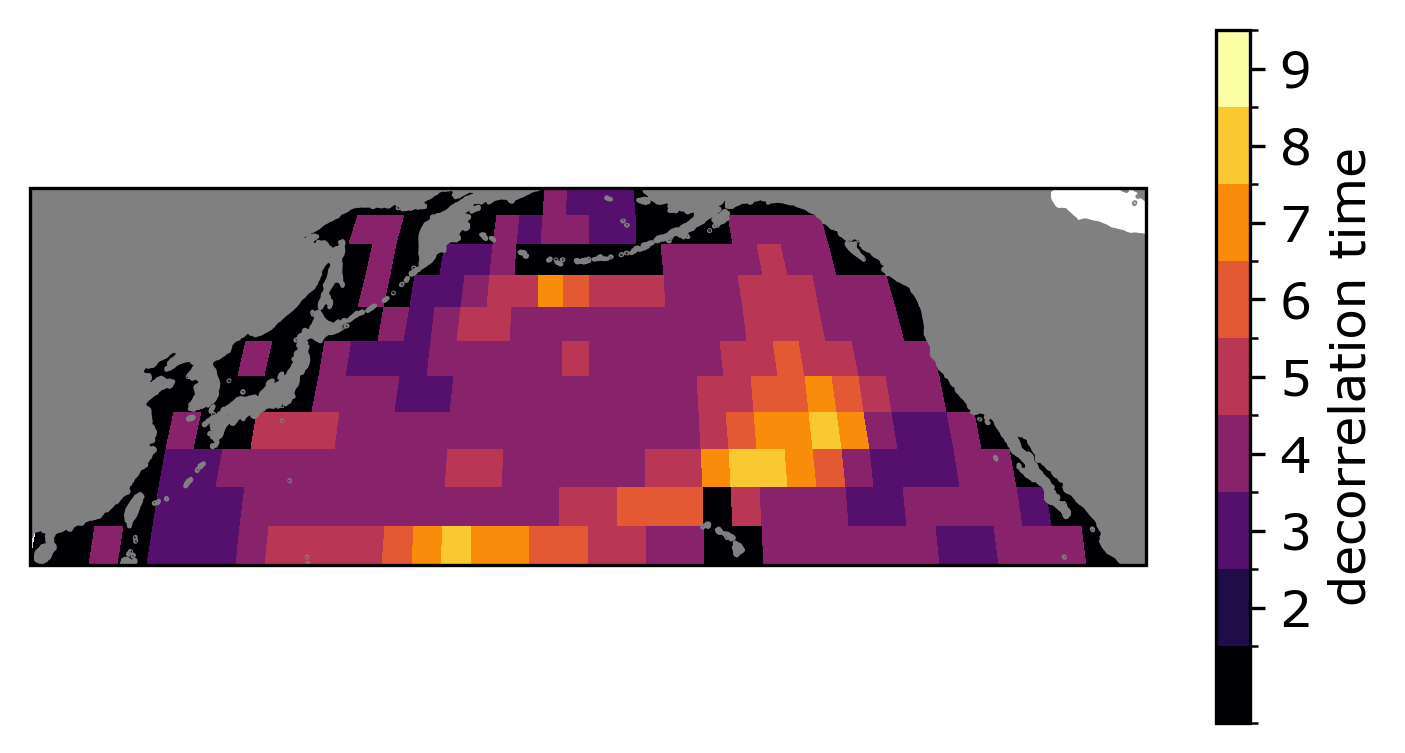

In [22]:
obs_f = np.fft.fft(outputobs_ERSST,axis=0)
obs_f_auto = obs_f * np.conjugate(obs_f)

obs_auto = np.fft.ifft(obs_f_auto,axis=0)
obs_auto = np.real(obs_auto[:30]/np.max(obs_auto,axis=0))

autotime = np.argmin(np.abs(obs_auto-np.exp(-1)),axis=0)

cmaptau = plt.get_cmap("inferno")
bounds = np.arange(0.5,10.5,1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmaptau.N)

plt.figure(figsize=(6,3))
a=plt.subplot(1,1,1,projection=projection)
c1=a.pcolormesh(lon,lat,autotime,norm=norm,cmap=cmaptau,transform=transform)
a.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey'))
cbar=plt.colorbar(c1,ticks=np.arange(2,11))
cbar.ax.set_ylabel("decorrelation time")

In [23]:
nboots = 5000

pearsonboots_CNNSC = np.empty((nboots,len(lat),len(lon)))+np.nan
pearsonboots_CNNraw = np.empty((nboots,len(lat),len(lon)))+np.nan
pearsonboots_persistence = np.empty((nboots,len(lat),len(lon)))+np.nan

persistence_true = outputobs_ERSST[run:]
persistence_pred = outputobs_ERSST[:-1*run]

for ilat,_ in enumerate(lat):
    for ilon,_ in enumerate(lon):

        blocklength = float(autotime[ilat,ilon])
        if blocklength > 0:
            # print(blocklength)
            nsel = int(np.ceil(len(persistence_true)/blocklength))
            indexmatrix = np.asarray([np.arange(i,i+blocklength,dtype=int) for i in range(len(persistence_true))])

            for iboot in range(nboots):

                inds = np.random.choice(np.arange(persistence_pred.shape[0]),size=(nsel+20),replace=True)
                samps = indexmatrix[inds,:].flatten()
                samps = samps[samps<len(persistence_true)]
                samps = samps[:len(persistence_true)]

                pearsonboots_CNNSC[iboot,ilat,ilon],_ = pearsonr(outputobs_pred[samps+run,ilat,ilon],outputobs_ERSST[samps+run,ilat,ilon]) # account persistence containing "run" fewer predicitons
                pearsonboots_CNNraw[iboot,ilat,ilon],_ = pearsonr(outputobs_ERSST[samps+run,ilat,ilon],y_pred_obs_ERSST[samps+run,ilat,ilon])

                pearsonboots_persistence[iboot,ilat,ilon],_ = pearsonr(persistence_true[samps,ilat,ilon],persistence_pred[samps,ilat,ilon])



/var/folders/84/qffj5kdx3q15s9xdytp7r01r0000gq/T/ipykernel_15588/3957766586.py:3: RuntimeWarning: invalid value encountered in add
  pearsonboots_CNNSC = np.empty((nboots,len(lat),len(lon)))+np.nan


#### But thats not all
We then use a t-test to calculate whether the CNN forecasts are significantly different from the persistence baseline. BUT t-tests want normal distributions and correlation coefficients are not normally distributed. Fortunately, $\rm{arctanh}$ transformed correlation coefficients are approximately normally distributed so we'll also do a lil' $\rm{arctanh}$ transformation on the correlation coefficients first. 

Fun fact, this transformation is also called a Fisher transformation, but he was a eugenicist so we are going to call it an $\rm{arctanh}$ transform instead.

We state our confidence level as 0.05, so CNN forecasts where the t-statistic is greater than zero, and p-value less than 0.05 are significantly better than persistence.

In [24]:
CNNSC_sig,CNNSC_p = ttest_ind(np.arctanh(pearsonboots_CNNSC),np.arctanh(pearsonboots_persistence),axis=0) 
CNNraw_sig,CNNraw_p = ttest_ind(np.arctanh(pearsonboots_CNNraw),np.arctanh(pearsonboots_persistence),axis=0)

CNNSC_mask = (CNNSC_sig>0) & (CNNSC_p<=0.05)
CNNraw_mask = (CNNraw_sig>0) & (CNNraw_p<=0.05)

lonsig,latsig = np.meshgrid(lon,lat)

lonsig[~landmask] = np.nan
latsig[~landmask] = np.nan


/var/folders/84/qffj5kdx3q15s9xdytp7r01r0000gq/T/ipykernel_15588/135840545.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


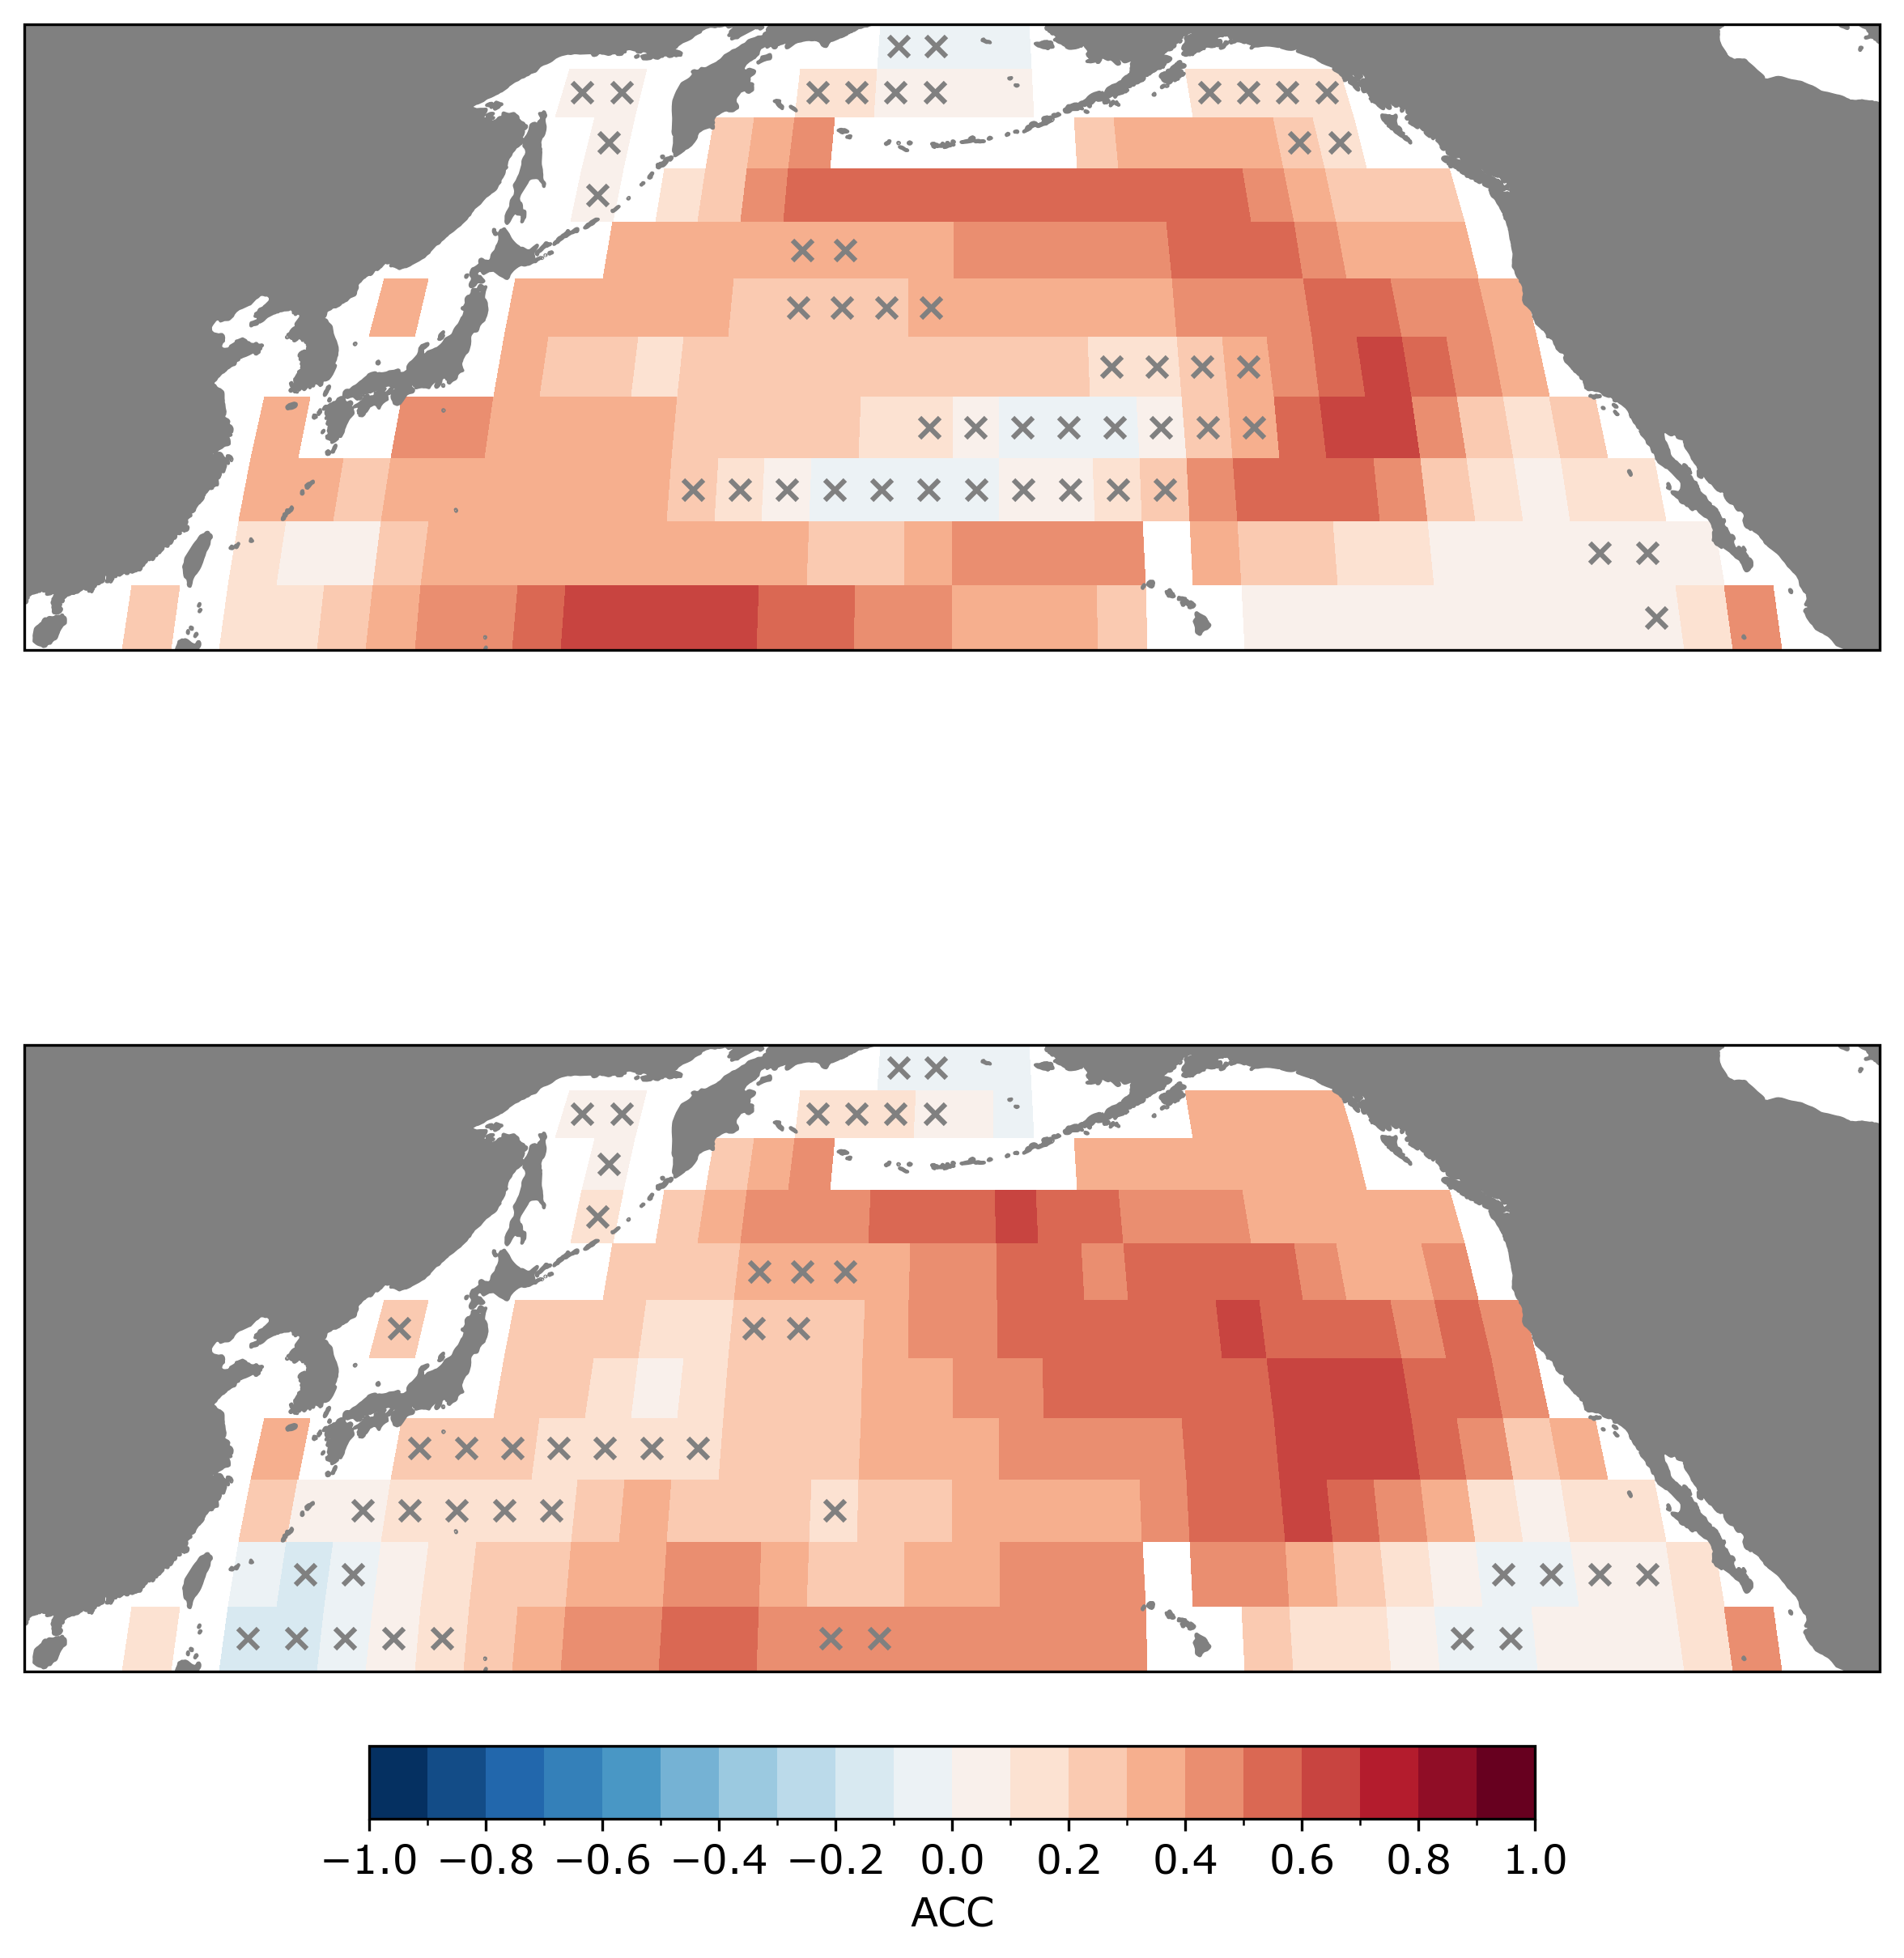

In [25]:
lbound = -1
ubound = 1

cmapdiv = plt.get_cmap("RdBu_r")
bounds = np.arange(lbound,ubound+0.1,0.1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmapdiv.N)
norm2 = colors.BoundaryNorm(boundaries=np.arange(-0.5,0.55,0.05), ncolors=cmapdiv.N)

plt.figure(figsize=(8,10))

a0=plt.subplot(2,1,1,projection=projection)

c0=a0.pcolormesh(lon,lat,outputobs_ACC_raw,norm=norm,cmap=cmapdiv,transform=transform)
a0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey'))
a0.scatter(lonsig[~CNNraw_mask],latsig[~CNNraw_mask],marker='x',transform=transform,color='gray')
# cbar=plt.colorbar(c0)
# plt.title("c. CNN-only")

a1=plt.subplot(2,1,2,projection=projection)
c1=a1.pcolormesh(lon,lat,outputobs_ACC,norm=norm,cmap=cmapdiv,transform=transform)
a1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey'))
a1.scatter(lonsig[~CNNSC_mask],latsig[~CNNSC_mask],marker='x',transform=transform,color='gray')
# cbar=plt.colorbar(c1)
# plt.title("d. CNN-SC")

cax=plt.axes((0.2,0.1,0.6,0.03))
cbar=plt.colorbar(c0,cax=cax,orientation='horizontal')
cbar.ax.set_xlabel(r'ACC')
cbar.ax.set_xticks(np.arange(-1,1.2,0.2))
plt.tight_layout()

plt.savefig("figures/ACC.png",dpi=300)

plt.show()

In [26]:
imp.reload(SCA)
SCAobj = SCA.SCA(y_pred_val,outputval,landmask,weights)

In [27]:
SCAobj.bestpattern
index_true = SCAobj.index_timeseries(outputobs_ERSST)
index_pred = SCAobj.index_timeseries(y_pred_obs_ERSST)

In [28]:
sc_f = np.fft.fft(index_true)
sc_f_auto = sc_f*np.conjugate(sc_f)
sc_auto = np.real(np.fft.ifft(sc_f_auto))
sc_auto = sc_auto/np.max(sc_auto)

scblock = np.argmin(np.abs(sc_auto-np.exp(-1)))

In [29]:
persistence = index_true[:-run]
indexmatrix = np.asarray([np.arange(i,i+scblock,dtype=int) for i in range(len(persistence_true))])

CNNcorr = np.empty(5000)
persistencecorr = np.empty(5000)

for iboot in range(5000):
    inds = np.random.choice(np.arange(persistence_pred.shape[0]),size=(nsel+20),replace=True)
    samps = indexmatrix[inds,:].flatten()
    samps = samps[samps<len(persistence_true)]
    samps = samps[:len(persistence_true)]

    CNNcorr[iboot],_ = pearsonr(index_true[run+samps],index_pred[run+samps])
    persistencecorr[iboot],_ = pearsonr(index_true[run+samps],persistence[samps])

    

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   1.,   0.,   0.,   1.,   1.,   1.,   2.,   3.,   0.,   1.,
          3.,   6.,   3.,   5.,   4.,   3.,   6.,  12.,  10.,  13.,  19.,
         17.,  14.,  17.,  14.,  19.,  25.,  38.,  42.,  40.,  45.,  43.,
         46.,  55.,  56.,  64.,  67.,  74., 101.,  89.,  88., 106.,  81.,
        101., 118., 133., 107., 125., 111., 132., 130., 138., 143., 132.,
        125., 129., 116., 119., 121., 111., 105., 127.,  99., 111., 109.,
        112., 105.,  92.,  88.,  73.,  71.,  66.,  50.,  52.,  54.,  41.,
         36.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

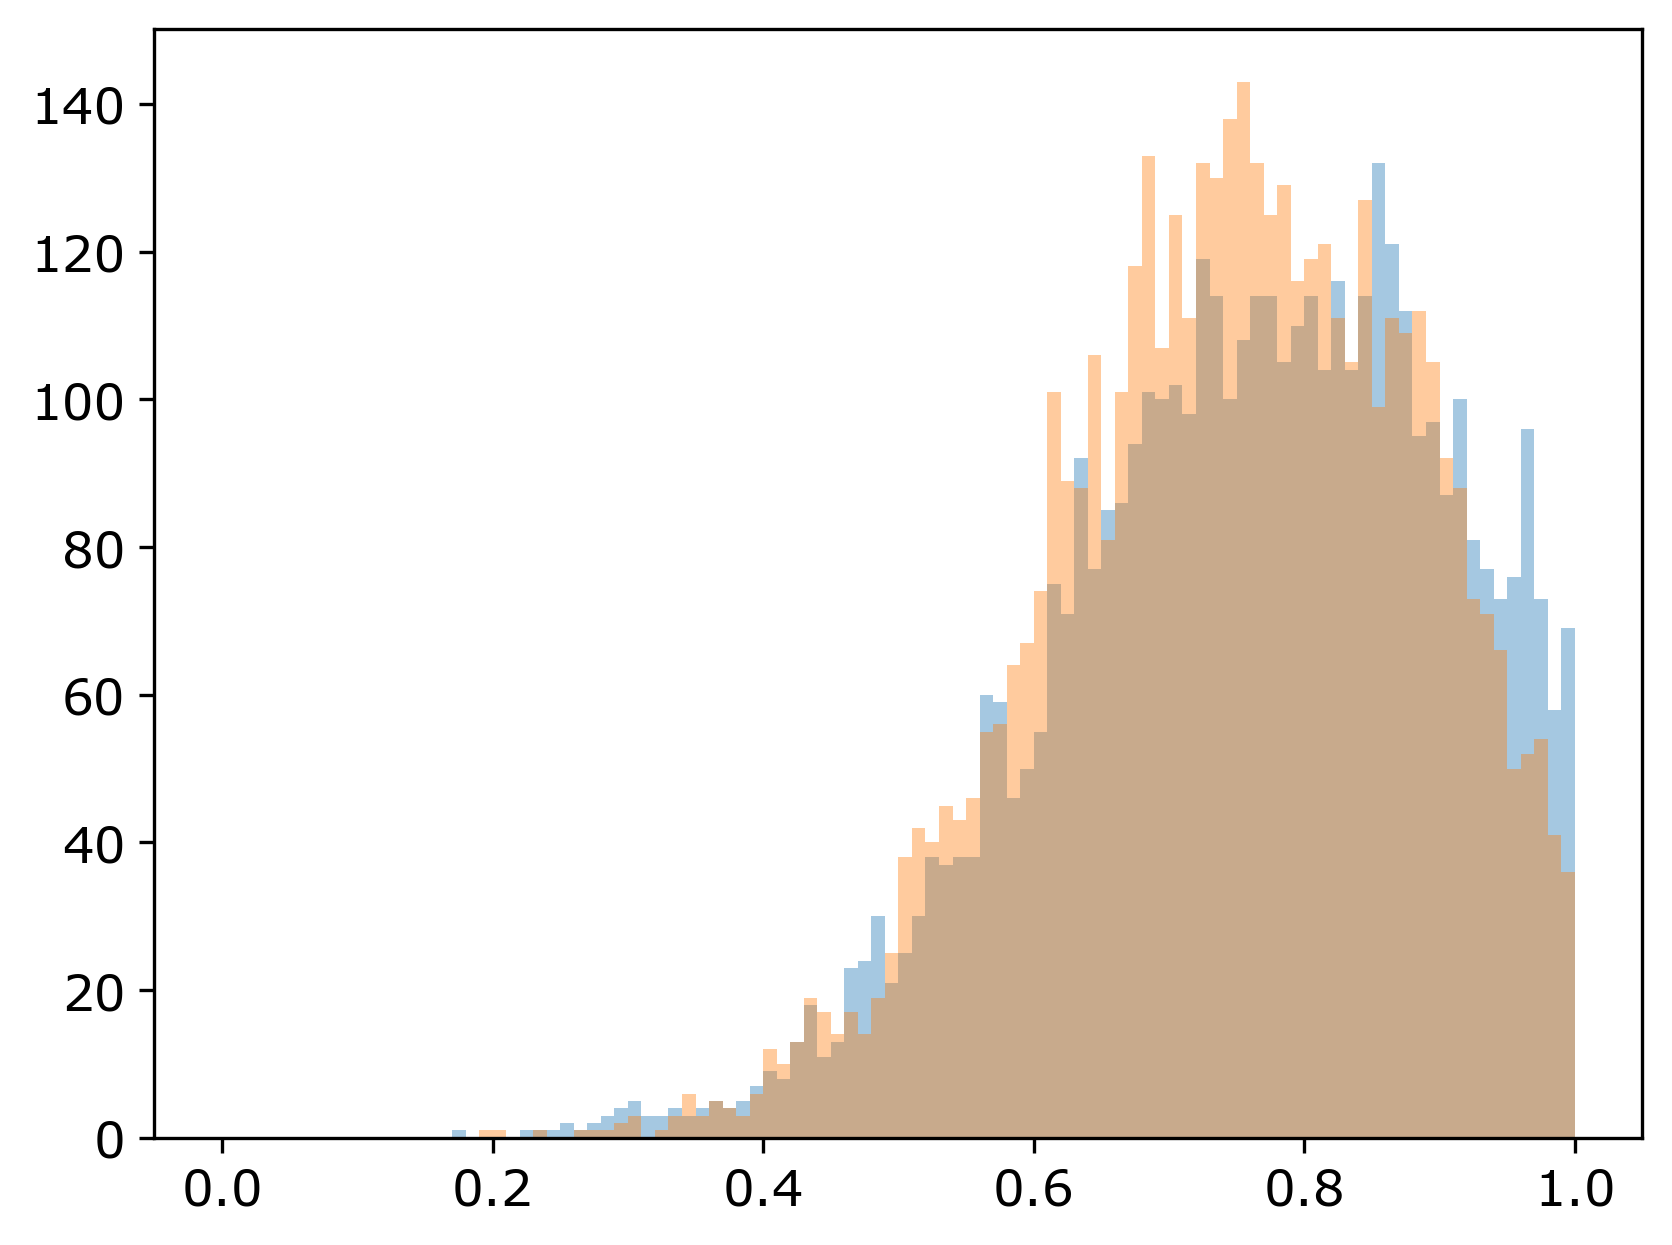

In [30]:
plt.hist(np.arctanh(CNNcorr),bins=np.arange(0,1.01,0.01),alpha=0.4)
plt.hist(np.arctanh(persistencecorr),bins=np.arange(0,1.01,0.01),alpha=0.4)

In [31]:
teststat = ttest_ind(np.arctanh(CNNcorr),np.arctanh(persistencecorr),equal_var=False)

In [32]:
teststat

TtestResult(statistic=8.831015068397974, pvalue=1.213656848639327e-18, df=9878.853090300729)